# Imports

In [105]:
# local imports
from scripts.data import generate_random_simulation, generate_features, SimulationData, save_result, load_result
from scripts.nn import create_autoencoder_model, train_encoder, train_encoder_with_constraints
from scripts.loss import recovery_loss, fixed_points_loss, subsequent_distances_loss, angle_differences_loss, imu_loss, angle_change_loss
from scripts.visualization import plot_loss_evolution, plot_multiloss_evolution, plot_embedding,plot_embedding_on_simulation, plot_embedding_pca, merge_losses

# pytorch
import torch
from torch import optim
from torch import nn
from torch.nn.functional import mse_loss, relu

# data manipulation
import numpy as np
from os.path import join, exists
from os import mkdir
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import chain
import tqdm

# visualization
from matplotlib import pyplot as plt
import seaborn

# Setup

### Parameters

#### Data paremeters

In [2]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

DATA_PATH = 'data/'
SIMULATIONS_FILE_NAME = join(DATA_PATH, 'generated_simulations.pt')
ANCHORS_FILE_NAME = join(DATA_PATH, 'anchors_pos.pt')

#### Neural network parameters

In [3]:
BATCH_SIZE = 1
N_EPOCHS = 500

#### generate data

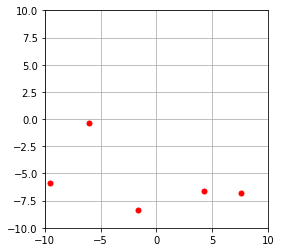

In [4]:
anchors_pos = torch.stack((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_ANCHORS),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_ANCHORS)
), 1)

plt.figure(figsize=(4,4))
plt.plot(*anchors_pos.T, '.r', markersize=10)
plt.xlim([MIN_X, MAX_X])
plt.ylim([MIN_Y, MAX_Y])
plt.grid(True);

In [22]:
simulations = torch.stack([
    generate_random_simulation(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS)
for i in range(N_SIMULATIONS)])

#### save data

In [27]:
torch.save(simulations, SIMULATIONS_FILE_NAME)
torch.save(anchors_pos, ANCHORS_FILE_NAME)

#### load data 

In [9]:
simulations = torch.load(SIMULATIONS_FILE_NAME)
anchors_pos = torch.load(ANCHORS_FILE_NAME)

In [10]:
data = SimulationData(simulations, anchors_pos)

#### Data visualization

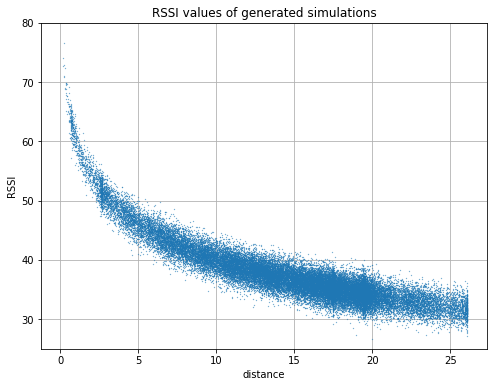

In [7]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RSSI')
plt.ylim([25, 80])
plt.title('RSSI values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,0].flatten(), '.', markersize=0.5)

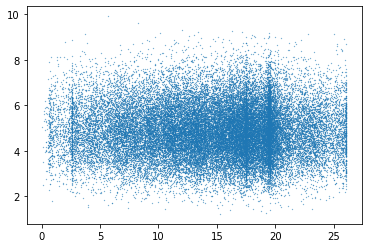

In [8]:
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,5].flatten(), '.', markersize=0.5)

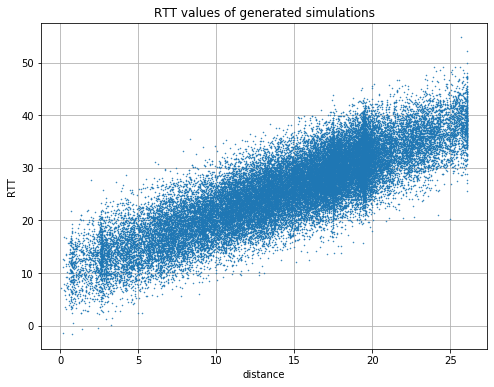

In [9]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RTT')
plt.title('RTT values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,10].flatten(), '.', markersize=1)

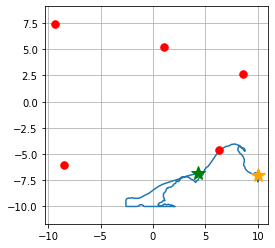

In [10]:
plt.figure(figsize=(4,4))
data.plot_simulation(data[0][1])

# Autoencoder

Autoencoder with one hidden layer of 12 units

In [11]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = 3 * N_ANCHORS
bot_dims = [2,3,4,5,6]
hid_dim = 12
n_dims = len(bot_dims)

## Unconstrained autoencoder

### Testing different embedding dimensions

Train autoencoder with bottleneck sizes of $[2,3,4,5,6]$

In [12]:
%%time

results = {}
for bot_dim in bot_dims:
    model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_loss, test_loss = train_encoder(model, train_loader, test_loader, N_EPOCHS, optimizer)
    
    results[bot_dim] = {
        'model': model,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

CPU times: user 11min, sys: 8.71 s, total: 11min 8s
Wall time: 11min 24s


In [16]:
# Save results
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    save_result(results[bot_dim], results_name)

In [17]:
# Load results
results = {}
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    results[bot_dim] = load_result(results_name, create_autoencoder_model(input_dim, hid_dim, bot_dim))

---

Train and test error for each embedding dimension

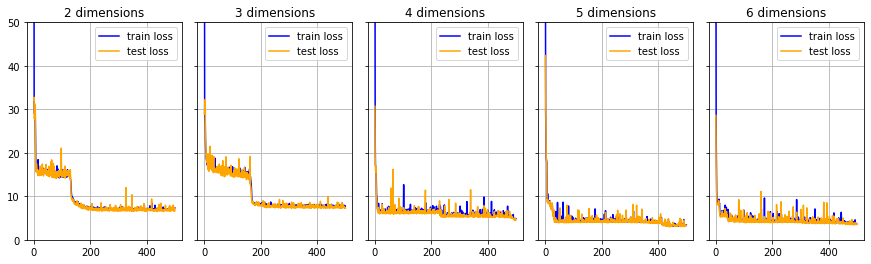

In [18]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 4))
plt.grid()
plt.subplots_adjust(wspace=0.1)

for i in range(n_dims):
    bot_dim = bot_dims[i]
    
    ax[i % 5].grid(True)
    ax[i % 5].plot(results[bot_dim]['train_loss'], c='blue')
    ax[i % 5].plot(results[bot_dim]['test_loss'], c='orange')
    ax[i % 5].legend(['train loss', 'test loss'])
    ax[i % 5].set_title(f'{bot_dim} dimensions')
    
plt.ylim(0, 50);

It looks like the 2 dimension model didn't converge yet.

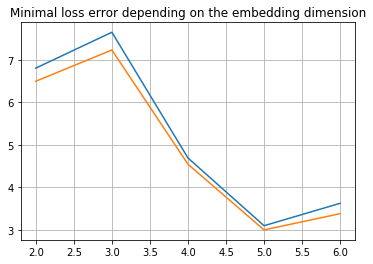

In [19]:
min_losses = {bot_dim: [min(results[bot_dim]['train_loss']), min(results[bot_dim]['test_loss'])] for bot_dim in bot_dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid(True)
plt.plot(bot_dims, [min_losses[bot_dim][0] for bot_dim in bot_dims])
plt.plot(bot_dims, [min_losses[bot_dim][1] for bot_dim in bot_dims]);

### 2-dimension embedding

Train an autoencoder with an embedding dimension of 2 for a longer time

In [16]:
model_2D = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
optimizer = optim.Adam(model_2D.parameters(), lr=0.005)

train_losses_2D, test_losses_2D = train_encoder(model_2D, train_loader, test_loader, 5 * N_EPOCHS, optimizer)
result_2D = {
    'model': model_2D,
    'train_loss': train_losses_2D,
    'test_loss': test_losses_2D
}

100%|██████████| 2500/2500 [11:13<00:00,  3.71it/s]


In [19]:
# Save result
result_name = 'autoencoder_2D_embedding_long'
save_result(result_2D, result_name)

In [20]:
# Load result
result_name = 'autoencoder_2D_embedding_long'
result_2D = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

---

Train and test loss of 2D embedding for longer time

(0, 25)

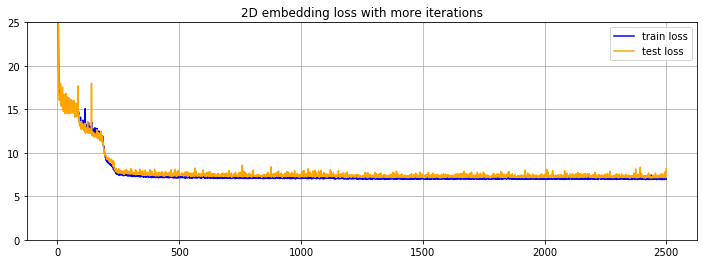

In [21]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D['train_loss'], result_2D['test_loss'])
plt.ylim([0,25])

2D embedding plots

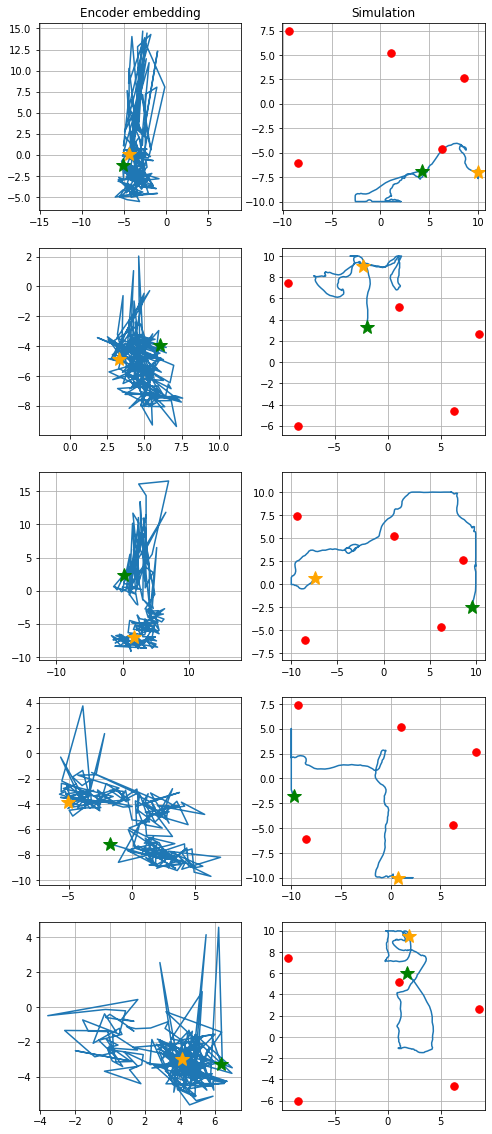

In [22]:
encoder, _ = result_2D['model']
plot_embedding(encoder, data, range(5))

#### Distance magnitude comparison

Compare if the distances magnitudes are proportional

In [19]:
encoded_data = encoder(data[:][0])
distance_matrix_input = pdist(data[2][0].view(-1, input_dim))
distance_matrix_encoded = pdist(encoded_data[2].view(-1, 2).detach())

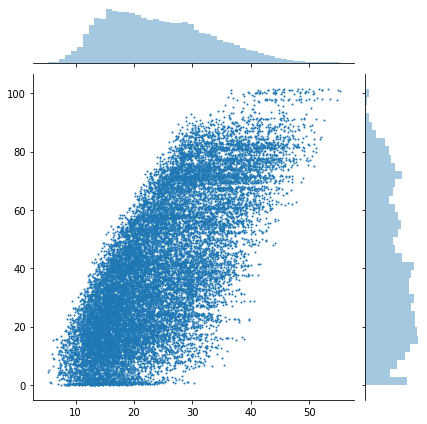

In [20]:
seaborn.jointplot(distance_matrix_input, distance_matrix_encoded, s=1)

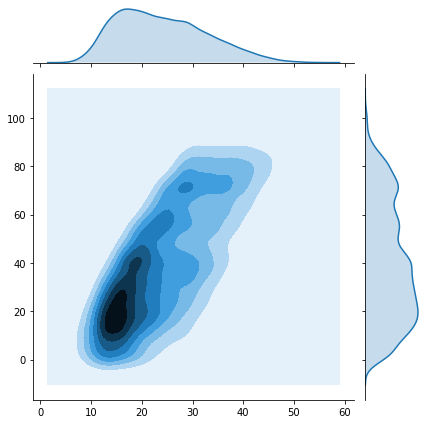

In [21]:
seaborn.jointplot(distance_matrix_input, distance_matrix_encoded, kind='kde')

### Comparison with PCA

Try pca 2D embedding and compare with autoencoder

In [22]:
pca = PCA(n_components=2)
pca_2D_embedding = pca.fit_transform(data[:][0].view(-1, input_dim))

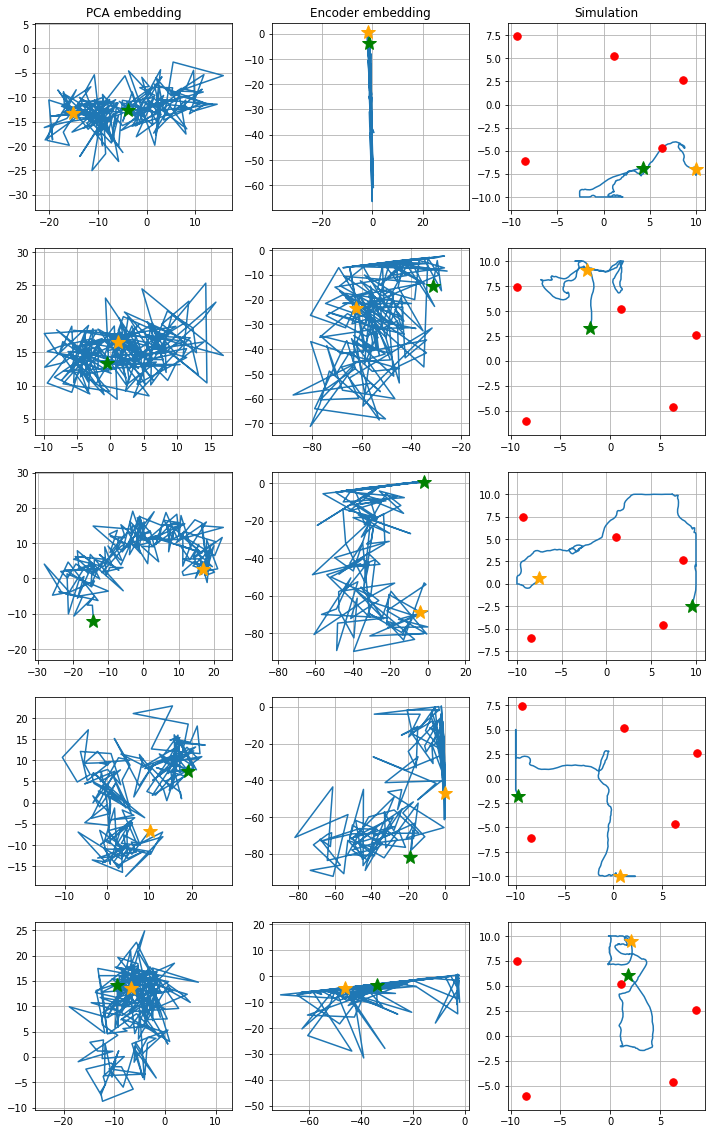

In [23]:
plot_embedding_pca(encoder, data, pca_2D_embedding.reshape((N_SIMULATIONS, N_STEPS, 2)), range(5))

In [24]:
pca_recovery_loss = mse_loss(data[:][0].view(N_SIMULATIONS * N_STEPS, input_dim), torch.FloatTensor(pca.inverse_transform(pca_2D_embedding)))
pca_recovery_loss

tensor(9.3651)

## Adding constraints

Add constraints as losses

### With subsequent distance constraint

#### Train

In [71]:
%%time

model_with_distance = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_distance, test_losses_with_distance = train_encoder_with_constraints(model_with_distance, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_distance = {
    'model': model_with_distance,
    'train_loss': train_losses_with_distance,
    'test_loss': test_losses_with_distance
}

CPU times: user 12min 5s, sys: 12.3 s, total: 12min 17s
Wall time: 12min 16s


#### Save result

In [72]:
# Save result
result_name = 'autoencoder_with_distance'
save_result(result_with_distance, result_name)

#### Load result

In [25]:
# Load result
result_name = 'autoencoder_with_distance'
result_with_distance = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

#### Visualize result

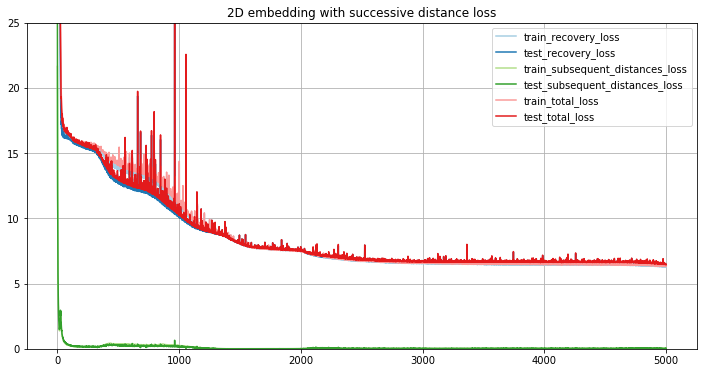

In [26]:
plot_multiloss_evolution(result_with_distance['train_loss'], result_with_distance['test_loss'])
plt.title('2D embedding with successive distance loss')
plt.ylim([0,25]);

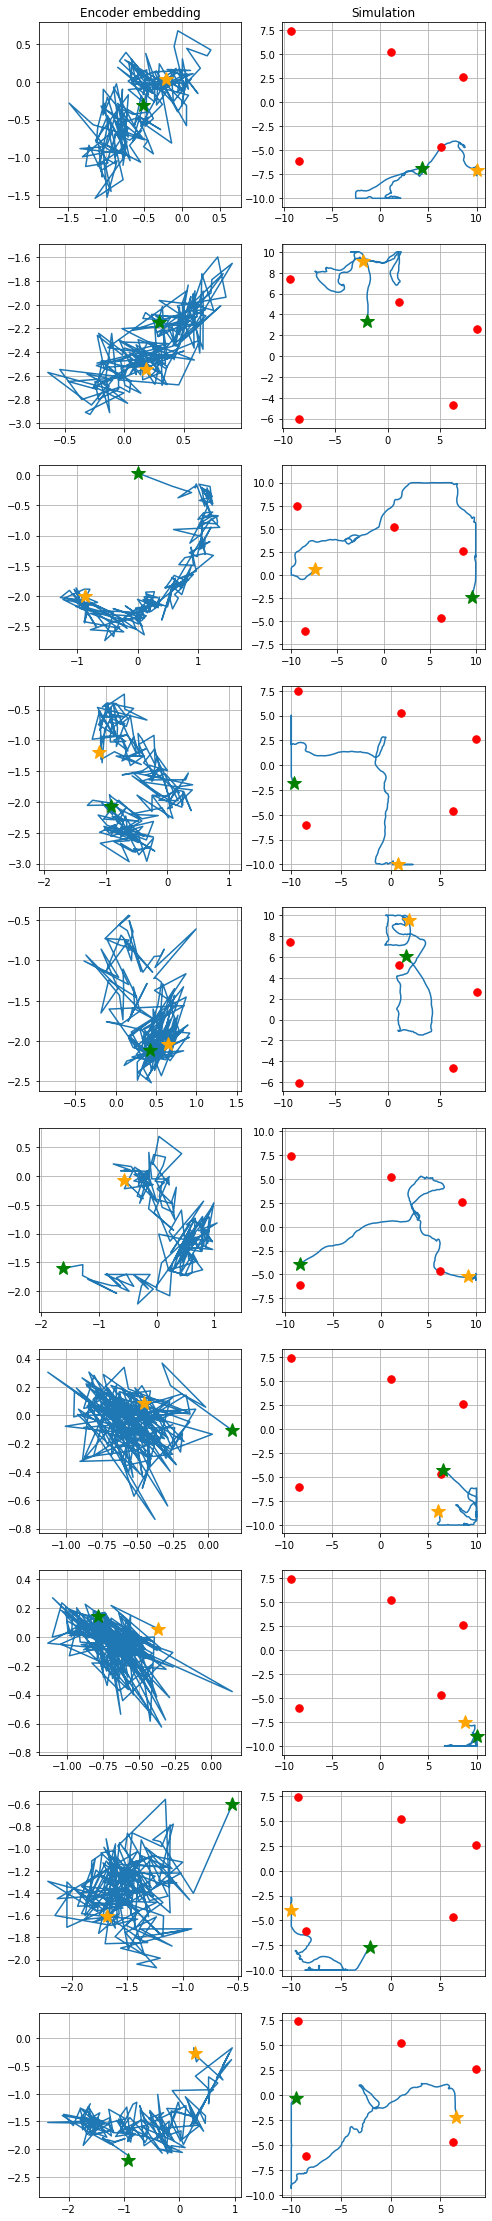

In [27]:
plot_embedding(result_with_distance['model'][0], data, range(10))

### With fixed points

#### Train

In [89]:
%%time

model_with_fixed_points = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

train_losses_with_fixed_points, test_losses_with_fixed_points = train_encoder_with_constraints(model_with_fixed_points, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_fixed_points = {
    'model': model_with_fixed_points,
    'train_loss': train_losses_with_fixed_points,
    'test_loss': test_losses_with_fixed_points
}

CPU times: user 10min 55s, sys: 12.9 s, total: 11min 8s
Wall time: 11min 7s


#### Save result

In [7]:
result_name = 'autoencoder_with_fixed_points'
save_result(result_with_fixed_points, result_name)

NameError: name 'result_with_fixed_points' is not defined

#### Load result

In [28]:
# Load result
result_name = 'autoencoder_with_fixed_points'
result_with_fixed_points = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

#### Visualize result

Text(0.5, 1.0, '2D embedding with fixed points loss')

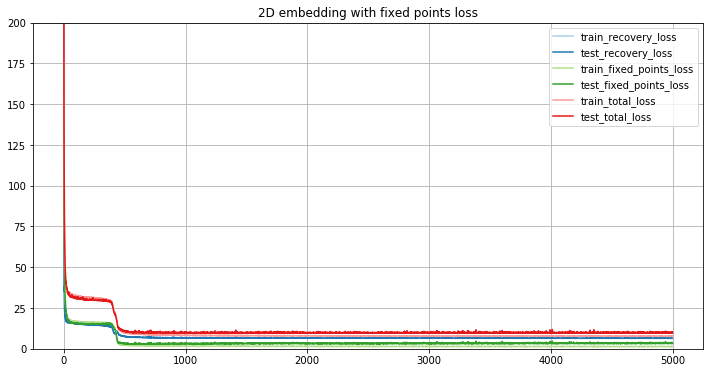

In [29]:
plot_multiloss_evolution(result_with_fixed_points['train_loss'], result_with_fixed_points['test_loss'])
plt.title('2D embedding with fixed points loss')

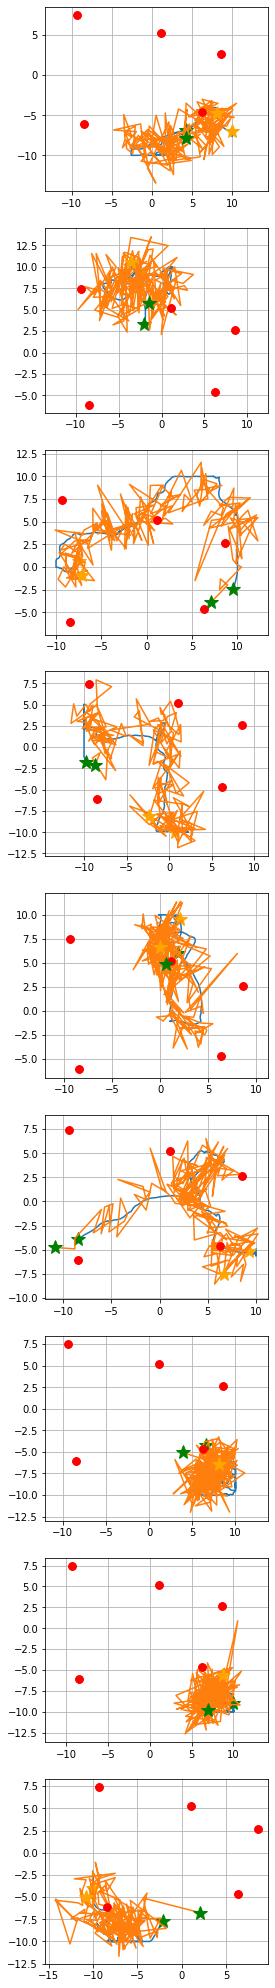

In [30]:
plot_embedding_on_simulation(result_with_fixed_points['model'][0], data, range(9))

### With angles

#### Train

In [95]:
%%time

model_with_angles = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': angle_differences_loss,
        'weight': 10
    }
]

train_losses_with_angles, test_losses_with_angles = train_encoder_with_constraints(model_with_angles, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_angles = {
    'model': model_with_angles,
    'train_loss': train_losses_with_angles,
    'test_loss': test_losses_with_angles
}

CPU times: user 15min, sys: 14.6 s, total: 15min 14s
Wall time: 15min 13s


#### Save result

In [96]:
result_name = 'autoencoder_with_angles'
save_result(result_with_angles, result_name)

#### Load result

In [31]:
result_name = 'autoencoder_with_angles'
result_with_angles = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

#### Visualize result

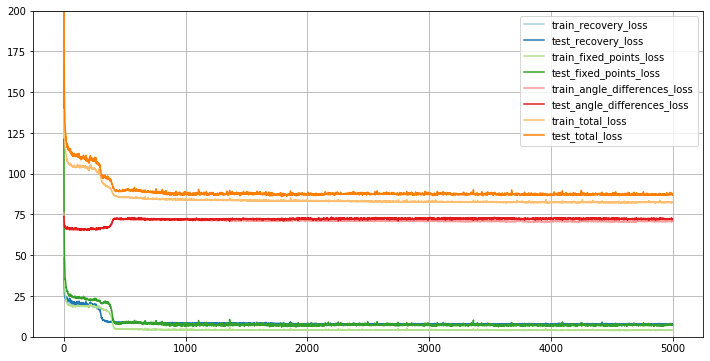

In [32]:
plot_multiloss_evolution(result_with_angles['train_loss'], result_with_angles['test_loss'])

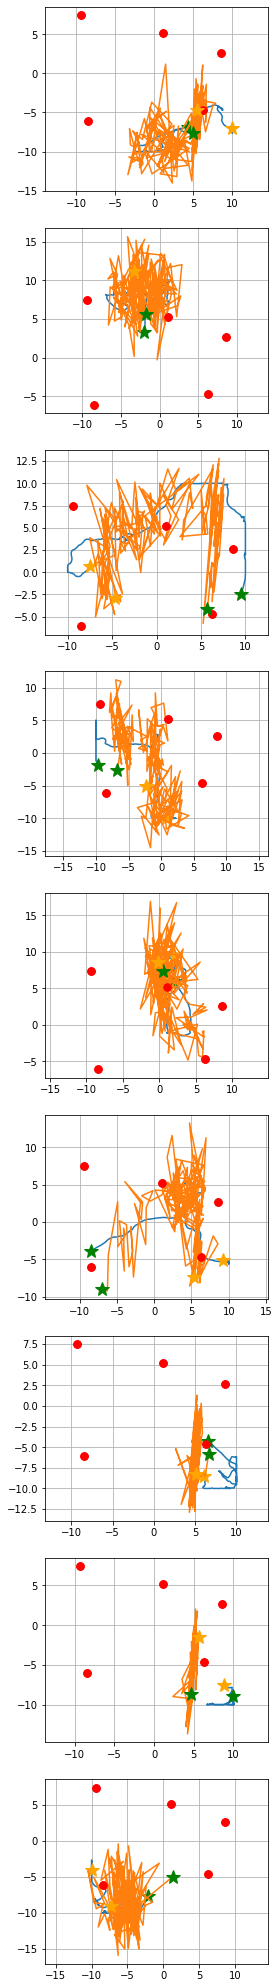

In [33]:
plot_embedding_on_simulation(result_with_angles['model'][0], data, range(9))

### With all constraints

#### Train

In [102]:
%%time

model_with_constraints = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints, test_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints,
    'test_loss': test_losses_with_constraints
}

CPU times: user 13min 19s, sys: 14.3 s, total: 13min 34s
Wall time: 13min 33s


#### Save result

In [103]:
result_name = 'autoencoder_with_constraints'
save_result(result_with_constraints, result_name)

#### Load result

In [34]:
# Load result
result_name = 'autoencoder_with_constraints'
result_with_constraints = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

#### Visualize result

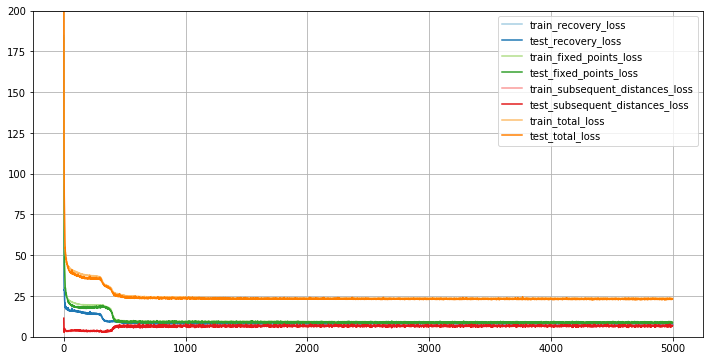

In [35]:
plot_multiloss_evolution(result_with_constraints['train_loss'], result_with_constraints['test_loss'])

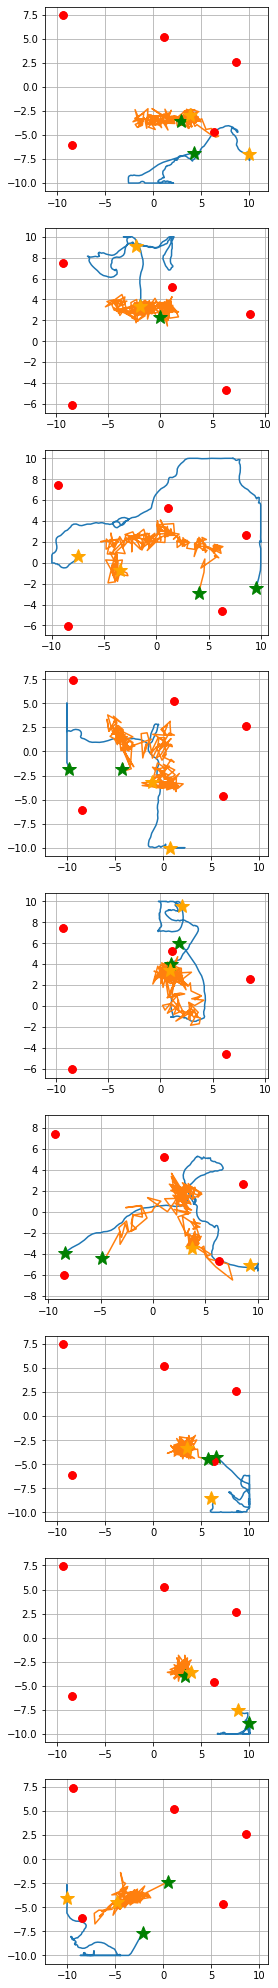

In [36]:
plot_embedding_on_simulation(result_with_constraints['model'][0], data, range(9))

### With changing loss

#### Train

In [71]:
model_with_changing_loss = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
optimizer = optim.Adam(model_with_changing_loss.parameters(), lr=0.001)

loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': imu_loss,
        'weight': [0]*(2 * N_EPOCHS) + np.linspace(0, 3, N_EPOCHS).tolist()
    }
]

train_losses_with_changing_loss, test_losses_with_changing_loss = train_encoder_with_constraints(model_with_changing_loss, train_loader, test_loader, 3 * N_EPOCHS, optimizer, loss_functions)

100%|██████████| 1500/1500 [09:35<00:00,  2.60it/s]


In [75]:
result_with_changing_loss = {
    'model': model_with_changing_loss,
    'train_loss': train_losses_with_changing_loss,
    'test_loss': test_losses_with_changing_loss
}

#### Save result

In [44]:
result_name = 'autoencoder_with_changing_loss'
save_result(result_with_changing_loss, result_name)

#### Load result

In [45]:
# Load result
result_name = 'autoencoder_with_changing_loss'
result_with_changing_loss = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

#### Visualize result

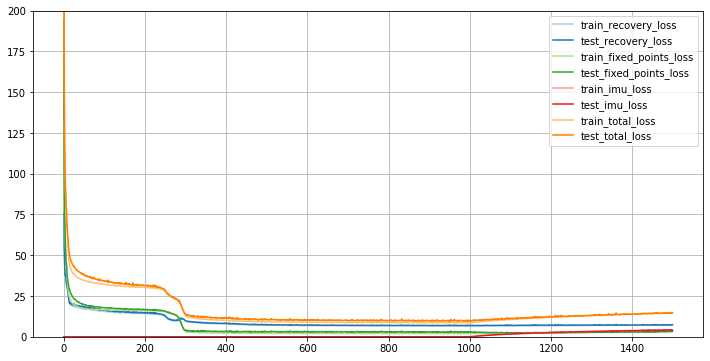

In [76]:
plot_multiloss_evolution(result_with_changing_loss['train_loss'], result_with_changing_loss['test_loss'])

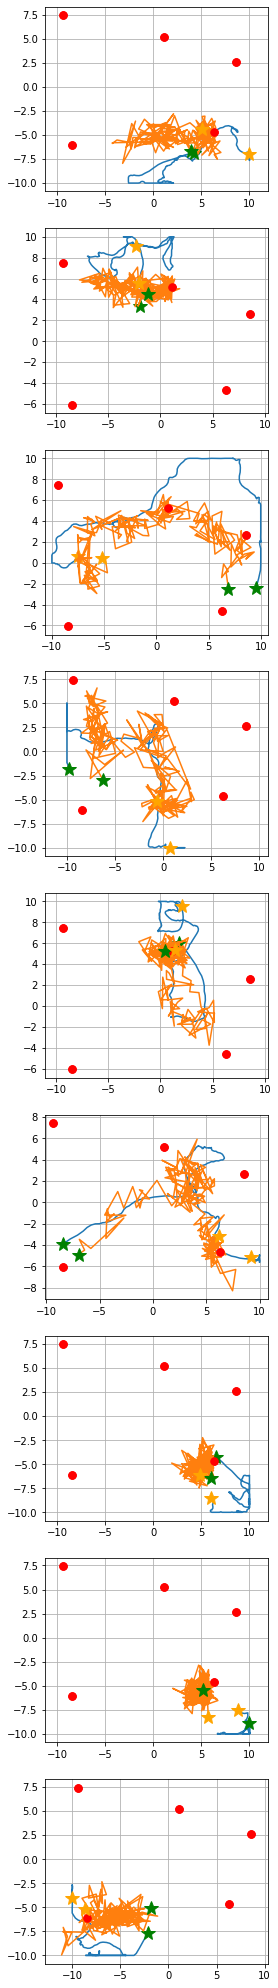

In [77]:
plot_embedding_on_simulation(result_with_changing_loss['model'][0], data, range(9))

### With changing loss 2 

#### Train

In [93]:
model_with_changing_loss2 = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
optimizer = optim.Adam(model_with_changing_loss2.parameters(), lr=0.001)

loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': [1.0]*(2 * N_EPOCHS) + np.linspace(1.0, 10, N_EPOCHS).tolist()
    }, {
        'function': imu_loss,
        'weight': [0.0]*(2 * N_EPOCHS) + np.linspace(0, 30, N_EPOCHS).tolist()
    }
]

train_losses_with_changing_loss2, test_losses_with_changing_loss2 = train_encoder_with_constraints(model_with_changing_loss2, train_loader, test_loader, 3 * N_EPOCHS, optimizer, loss_functions)

100%|██████████| 1500/1500 [08:19<00:00,  3.01it/s]


In [94]:
result_with_changing_loss2 = {
    'model': model_with_changing_loss2,
    'train_loss': train_losses_with_changing_loss2,
    'test_loss': test_losses_with_changing_loss2
}

#### Save result

In [88]:
result_name = 'autoencoder_with_changing_loss2'
save_result(result_with_changing_loss2, result_name)

#### Load result

In [97]:
# Load result
result_name = 'autoencoder_with_changing_loss2'
result_with_changing_loss2 = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

#### Visualize result

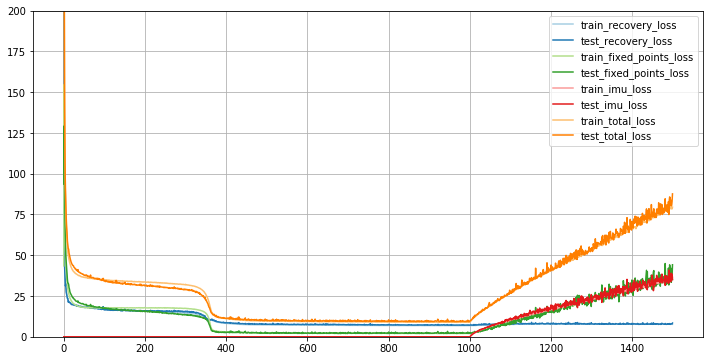

In [98]:
plot_multiloss_evolution(result_with_changing_loss2['train_loss'], result_with_changing_loss2['test_loss'])

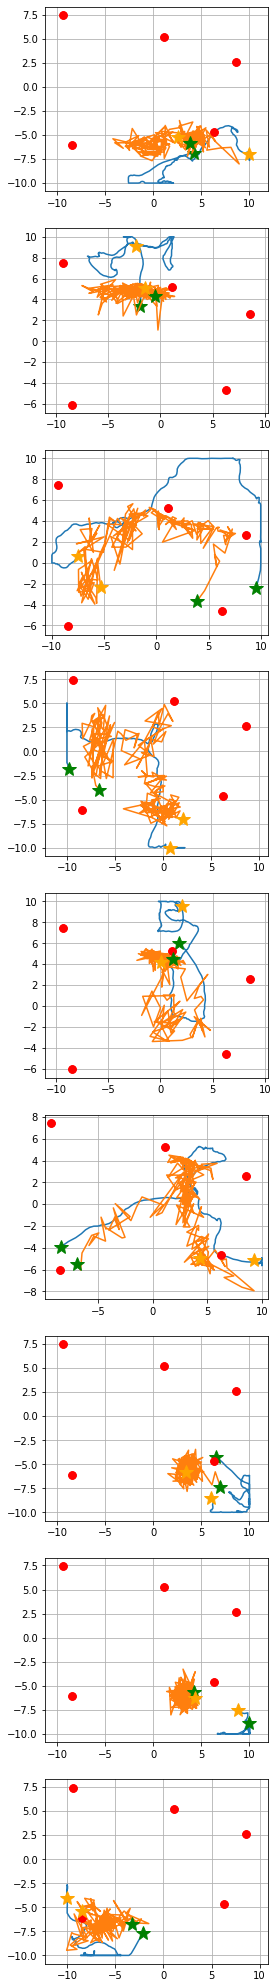

In [99]:
plot_embedding_on_simulation(result_with_changing_loss2['model'][0], data, range(9))

### With changing loss 3

#### Train

In [106]:
model_with_changing_loss3 = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
optimizer = optim.Adam(model_with_changing_loss3.parameters(), lr=0.001)

loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': angle_change_loss,
        'weight': [0.0]*(2 * N_EPOCHS) + np.linspace(0, 1, N_EPOCHS).tolist()
    }
]

train_losses_with_changing_loss3, test_losses_with_changing_loss3 = train_encoder_with_constraints(model_with_changing_loss3, train_loader, test_loader, 3 * N_EPOCHS, optimizer, loss_functions)

100%|██████████| 1500/1500 [10:55<00:00,  2.29it/s]


In [107]:
result_with_changing_loss3 = {
    'model': model_with_changing_loss3,
    'train_loss': train_losses_with_changing_loss3,
    'test_loss': test_losses_with_changing_loss3
}

#### Save result

In [110]:
result_name = 'autoencoder_with_changing_loss3'
save_result(result_with_changing_loss3, result_name)

#### Load result

In [111]:
# Load result
result_name = 'autoencoder_with_changing_loss3'
result_with_changing_loss3 = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

#### Visualize result

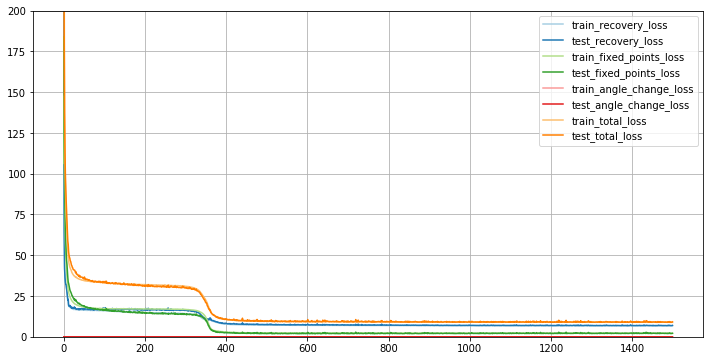

In [112]:
plot_multiloss_evolution(result_with_changing_loss3['train_loss'], result_with_changing_loss3['test_loss'])

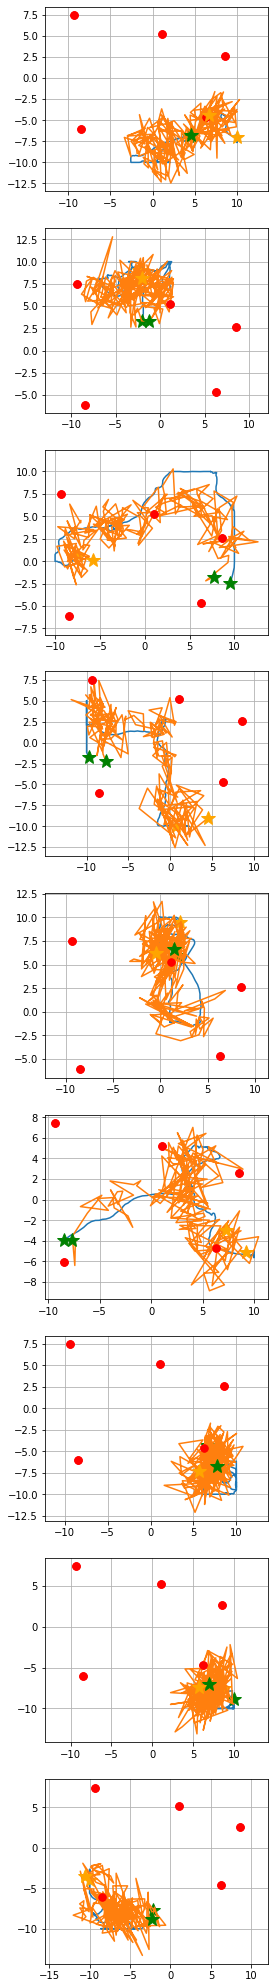

In [113]:
plot_embedding_on_simulation(result_with_changing_loss3['model'][0], data, range(9))

## Run in different configurations

### Configurations

In [37]:
n_experiments = 5

#### Anchor positions

##### Generate anchors

In [ ]:
#### anchors_pos_e1 = torch.FloatTensor([
    [-10, -10],
    [-10, 10],
    [10, -10],
    [10, 10],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e2 = torch.FloatTensor([
    [-5, -5],
    [-5, 5],
    [5, -5],
    [5, 5],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e3 = torch.FloatTensor([
    [-10, -10],
    [10, 10],
    [-3, 3],
    [3, -3],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e4 = torch.FloatTensor([
    [-10, -10],
    [-10, 0],
    [0, 0],
    [10, 0],
    [10, 10]
]) + torch.empty(5,2).normal_()

anchors_pos_e5 = torch.FloatTensor([
    [-10, -10],
    [-10, 0],
    [-10, 10],
    [0, 10],
    [10, 10]
]) + torch.empty(5,2).normal_()

anchors_pos_es = [anchors_pos_e1, anchors_pos_e2, anchors_pos_e3, anchors_pos_e4, anchors_pos_e5]

##### Save anchor positions

In [93]:
for idx in range(n_experiments):
    anchors_file_name_e = join(DATA_PATH, f'anchors_pos_e{idx}.pt')
    torch.save(anchors_pos_es[idx], anchors_file_name_e)

##### Load anchor positions

In [39]:
# Load anchor positions
anchors_pos_es = []
for idx in range(n_experiments):
    anchors_file_name_e = join(DATA_PATH, f'anchors_pos_e{idx}.pt')
    anchors_pos_e = torch.load(anchors_file_name_e)
    anchors_pos_es.append(anchors_pos_e)

### Train

In [69]:
%%time

# experiments = [
#     ...
#     }, {
#         'data': data,
#         'model': model,
#         'train_losses': train_losses,
#         'test_losses': test_losses
#     }, {
#     ...
# ]
experiments = []

for experiment_idx in range(n_experiments):
    data_e = SimulationData(simulations, anchors_pos_es[experiment_idx])
    train_loader_e, test_loader_e = data_e.get_random_loaders(0.8, BATCH_SIZE)
    model_e = create_autoencoder_model(input_dim, hid_dim, 2)
    loss_functions = [
        {
            'function': recovery_loss,
            'weight': 1.0
        }, {
            'function': fixed_points_loss,
            'weight': 1.0
        }, {
            'function': subsequent_distances_loss,
            'weight': 10.0
        }
    ]
    train_losses_e, test_losses_e = train_encoder_with_constraints(model_e, train_loader_e, test_loader_e, 40 * N_EPOCHS, loss_functions)
    experiments.append({
        'data': data_e,
        'model': model_e,
        'train_loss': train_losses_e,
        'test_loss': test_losses_e
    })

CPU times: user 4h 26min 45s, sys: 4min 39s, total: 4h 31min 24s
Wall time: 4h 30min 36s


### Save results

In [70]:
# Save experiments
for idx, experiment in enumerate(experiments):
    result_name = f'autoencoder_with_constraints_e{idx}'
    save_result({
        'model': experiment['model'],
        'train_loss': experiment['train_loss'],
        'test_loss': experiment['test_loss']
    }, result_name)

### Load results 

In [40]:
# Load experiments
experiments = []
for idx in range(n_experiments):
    result_name = f'autoencoder_with_constraints_e{idx}'
    result = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))
    
    experiment = {}
    experiment['model'] = result['model']
    experiment['train_loss'] = result['train_loss']
    experiment['test_loss'] = result['test_loss']
    experiment['data'] = SimulationData(simulations, anchors_pos_es[idx])
    experiments.append(experiment)

### Visualize results

########## EXPERIMENT 1 ##########


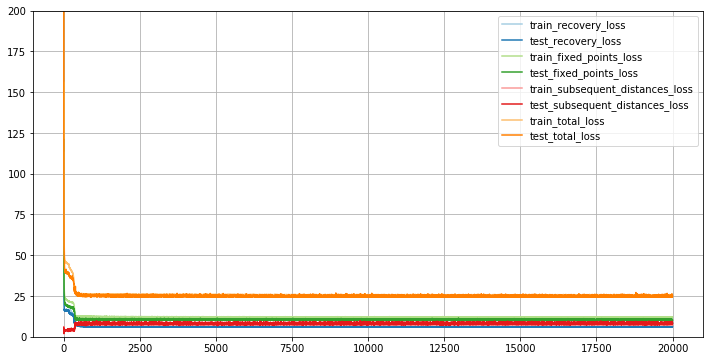

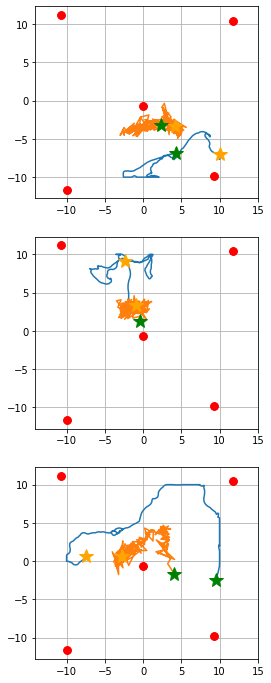

########## EXPERIMENT 2 ##########


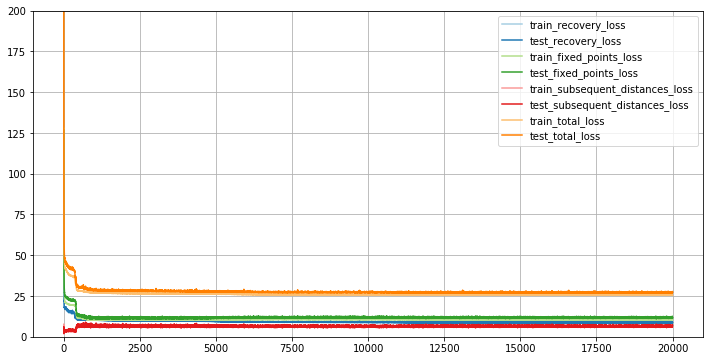

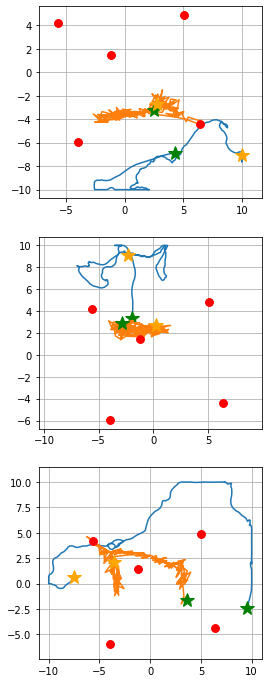

########## EXPERIMENT 3 ##########


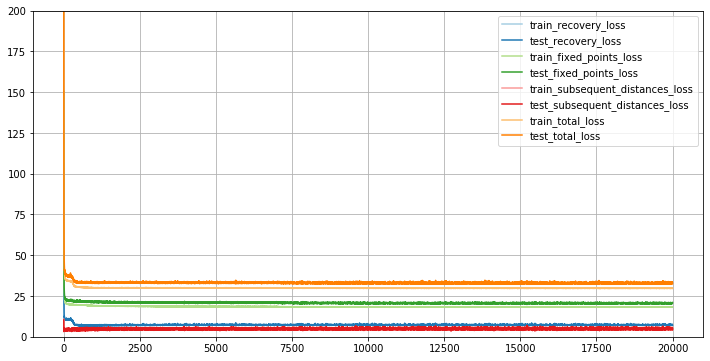

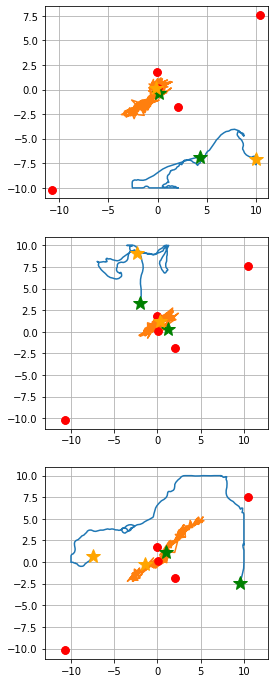

########## EXPERIMENT 4 ##########


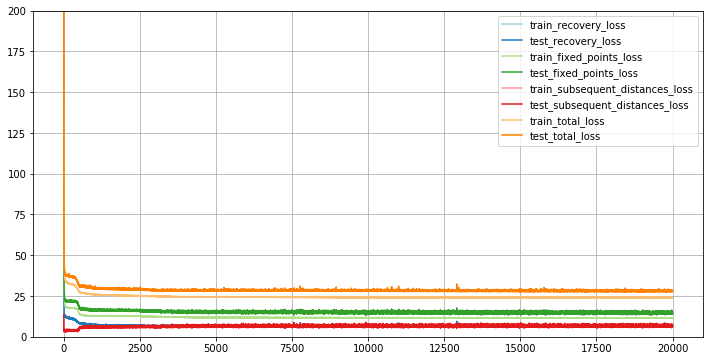

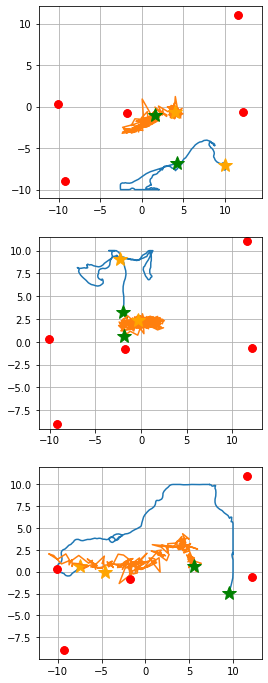

########## EXPERIMENT 5 ##########


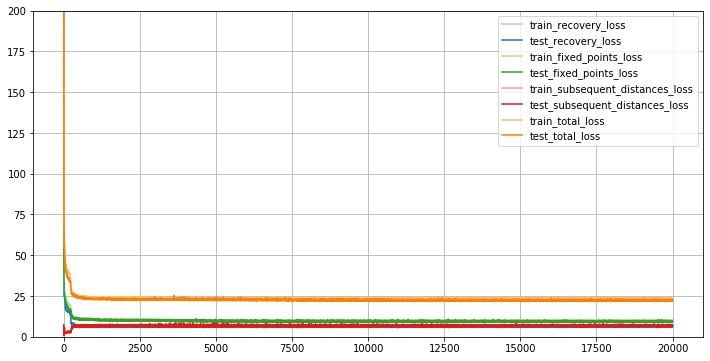

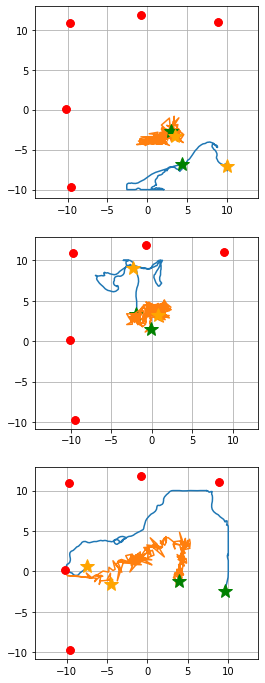

In [41]:
for idx, experiment in enumerate(experiments):
    print(f'########## EXPERIMENT {idx + 1} ##########')
    plot_multiloss_evolution(experiment['train_loss'], experiment['test_loss'])
    plt.show()
    plot_embedding_on_simulation(experiment['model'][0], experiment['data'], range(3))
    plt.show()
    

## Weighted recovery loss

### Split recovery loss

In [42]:
rssi_mean_indices = torch.arange(N_ANCHORS)
rssi_std_indices = N_ANCHORS + rssi_mean_indices
rtt_indices = N_ANCHORS + rssi_std_indices

print('rssi_mean_indices:', rssi_mean_indices.numpy())
print('rssi_std_indices:', rssi_std_indices.numpy())
print('rtt_indices:', rtt_indices.numpy())

rssi_mean_indices: [0 1 2 3 4]
rssi_std_indices: [5 6 7 8 9]
rtt_indices: [10 11 12 13 14]


In [43]:
def rssi_mean_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rssi_mean_indices], input[..., rssi_mean_indices])

In [44]:
def rssi_std_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rssi_std_indices], input[..., rssi_std_indices])

In [45]:
def rtt_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rtt_indices], input[..., rtt_indices])

In [122]:
%%time

model_with_split_recovery_loss = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rtt_recovery_loss,
        'weight': 1.0
    }
]

train_losses_with_split_recovery_loss, test_losses_with_split_recovery_loss = train_encoder_with_constraints(model_with_split_recovery_loss, train_loader, test_loader, 20 * N_EPOCHS, loss_functions)
result_with_split_recovery_loss = {
    'model': model_with_split_recovery_loss,
    'train_loss': train_losses_with_split_recovery_loss,
    'test_loss': test_losses_with_split_recovery_loss
}

CPU times: user 27min 23s, sys: 26.4 s, total: 27min 49s
Wall time: 27min 47s


In [123]:
# Save result
result_name = 'autoencoder_with_split_recovery_loss'
save_result(result_with_split_recovery_loss, result_name)

In [46]:
# Load result
result_name = 'autoencoder_with_split_recovery_loss'
result_with_split_recovery_loss = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

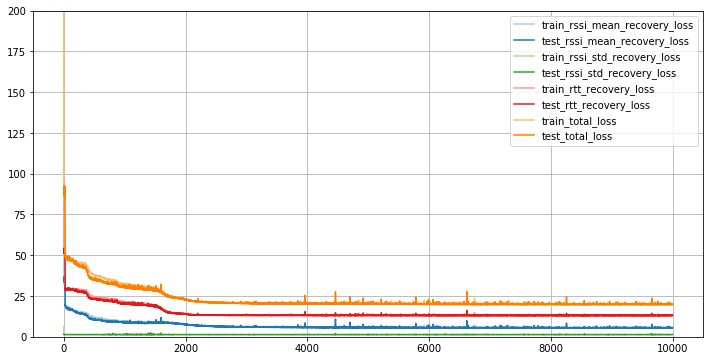

In [47]:
plot_multiloss_evolution(result_with_split_recovery_loss['train_loss'], result_with_split_recovery_loss['test_loss'])

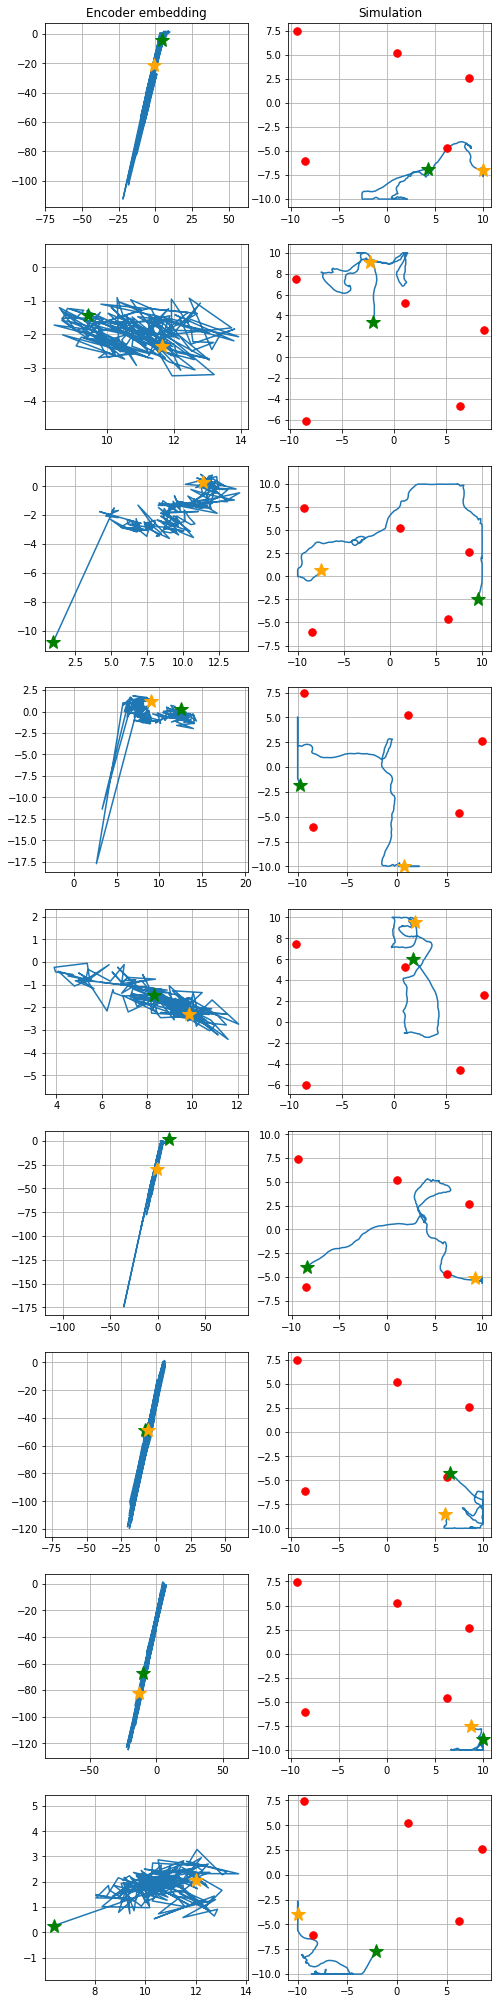

In [48]:
plot_embedding(result_with_split_recovery_loss['model'][0] , data, range(9))

### Split recovery loss with big weight on rtt

In [130]:
%%time

model_with_split_recovery_loss_big_rtt = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rtt_recovery_loss,
        'weight': 10.0
    }
]

train_losses_with_split_recovery_loss_big_rtt, test_losses_with_split_recovery_loss_big_rtt = train_encoder_with_constraints(model_with_split_recovery_loss_big_rtt, train_loader, test_loader, 20 * N_EPOCHS, loss_functions)
result_with_split_recovery_loss_big_rtt = {
    'model': model_with_split_recovery_loss_big_rtt,
    'train_loss': train_losses_with_split_recovery_loss_big_rtt,
    'test_loss': test_losses_with_split_recovery_loss_big_rtt
}

CPU times: user 27min 32s, sys: 27.9 s, total: 27min 59s
Wall time: 27min 57s


In [131]:
# Save result
result_name = 'autoencoder_with_split_recovery_loss_big_rtt'
save_result(result_with_split_recovery_loss_big_rtt, result_name)

In [49]:
# Load result
result_name = 'autoencoder_with_split_recovery_loss_big_rtt'
result_with_split_recovery_loss_big_rtt = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

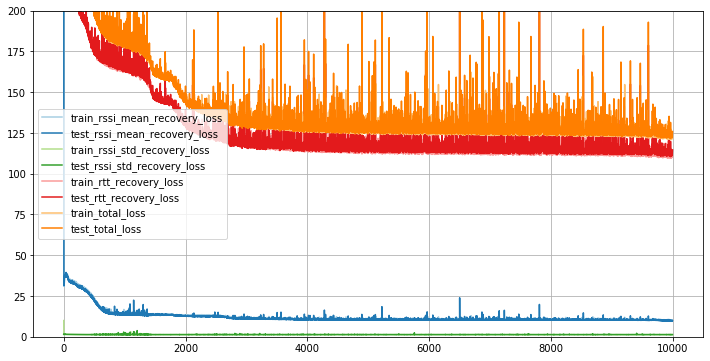

In [50]:
plot_multiloss_evolution(result_with_split_recovery_loss_big_rtt['train_loss'], result_with_split_recovery_loss_big_rtt['test_loss'])

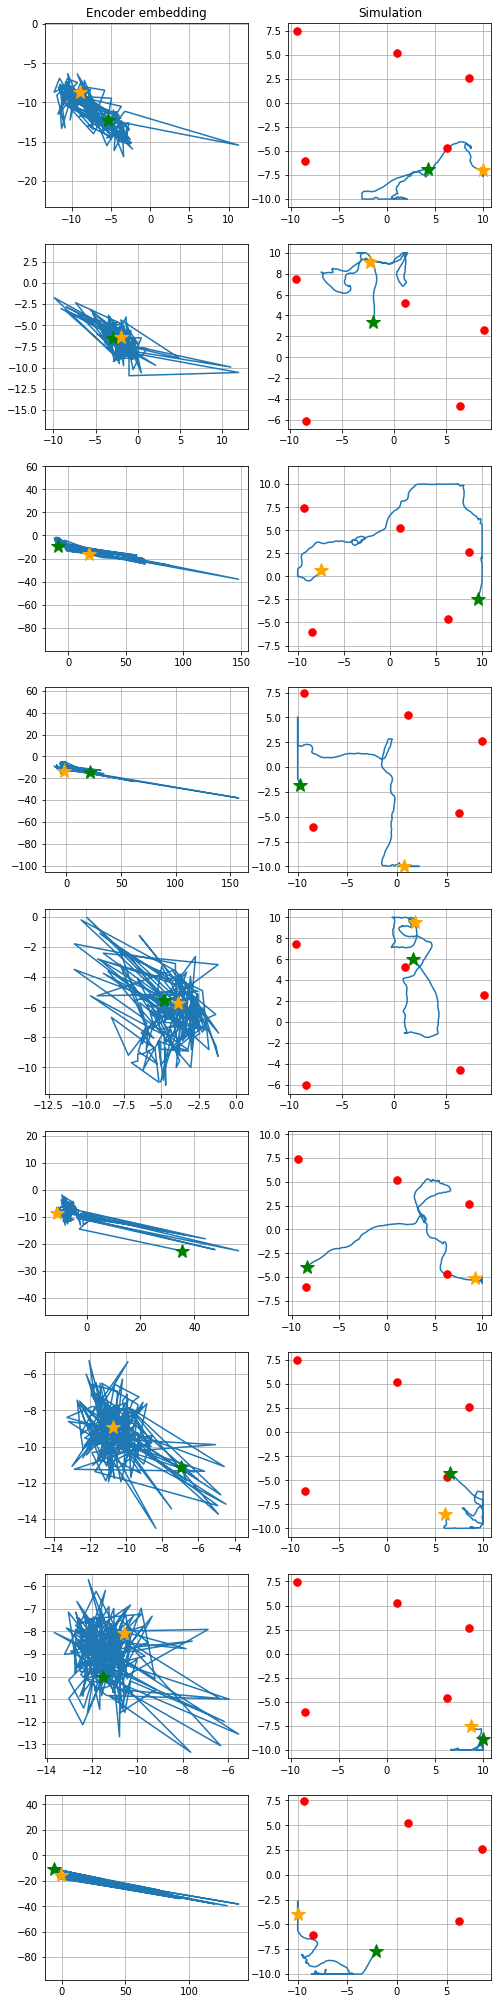

In [51]:
plot_embedding(result_with_split_recovery_loss_big_rtt['model'][0] , data, range(9))

### Rescaled recovery loss

In [52]:
data_stds = data[:][0].std((0,1))
data_stds

tensor([5.2342, 6.0776, 5.1721, 5.3616, 6.4506, 1.1580, 1.1524, 1.1630, 1.1590,
        1.1694, 7.4344, 7.3447, 6.3217, 6.6189, 8.0722])

In [53]:
out = result_with_split_recovery_loss['model'](data[:][0])
data[:][0].sub(out).pow(2).std((0,1))

tensor([ 7.3938, 17.1193, 22.1459,  9.8385, 12.3423,  1.9254,  1.9271,  1.9216,
         1.9213,  1.9579, 17.9551, 20.8436, 23.2091, 16.5592, 17.3196],
       grad_fn=<StdBackward1>)

In [54]:
rssi_mean_stds = data_stds[rssi_mean_indices]
rssi_std_stds = data_stds[rssi_std_indices]
rtt_stds = data_stds[rtt_indices]

In [55]:
def rescaled_rssi_mean_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rssi_mean_indices].sub(input[..., rssi_mean_indices]).pow(2).div(rssi_mean_stds).mean()

In [56]:
def rescaled_rssi_std_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rssi_std_indices].sub(input[..., rssi_std_indices]).pow(2).div(rssi_std_stds).mean()

In [57]:
def rescaled_rtt_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rtt_indices].sub(input[..., rtt_indices]).pow(2).div(rtt_stds).mean()

In [50]:
%%time

model_with_rescaled_recovery_loss = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 1.0
    }
]

train_losses_with_rescaled_recovery_loss, test_losses_with_rescaled_recovery_loss = train_encoder_with_constraints(model_with_rescaled_recovery_loss, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_rescaled_recovery_loss = {
    'model': model_with_rescaled_recovery_loss,
    'train_loss': train_losses_with_rescaled_recovery_loss,
    'test_loss': test_losses_with_rescaled_recovery_loss
}

CPU times: user 16min 3s, sys: 14.6 s, total: 16min 17s
Wall time: 16min 17s


In [51]:
# Save result
result_name = 'autoencoder_with_rescaled_recovery_loss'
save_result(result_with_rescaled_recovery_loss, result_name)

In [58]:
# Load result
result_name = 'autoencoder_with_rescaled_recovery_loss'
result_with_rescaled_recovery_loss = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

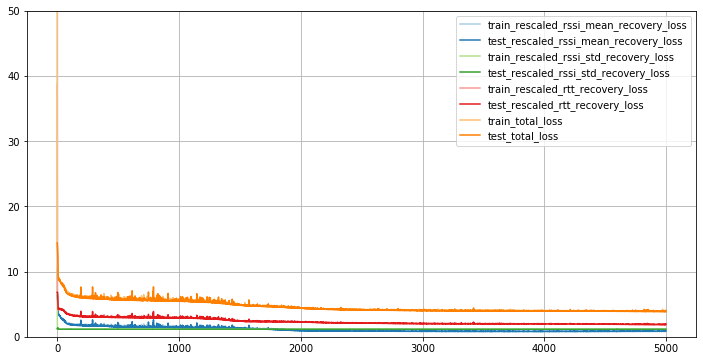

In [59]:
plot_multiloss_evolution(result_with_rescaled_recovery_loss['train_loss'], result_with_rescaled_recovery_loss['test_loss'], ylim=[0,50])

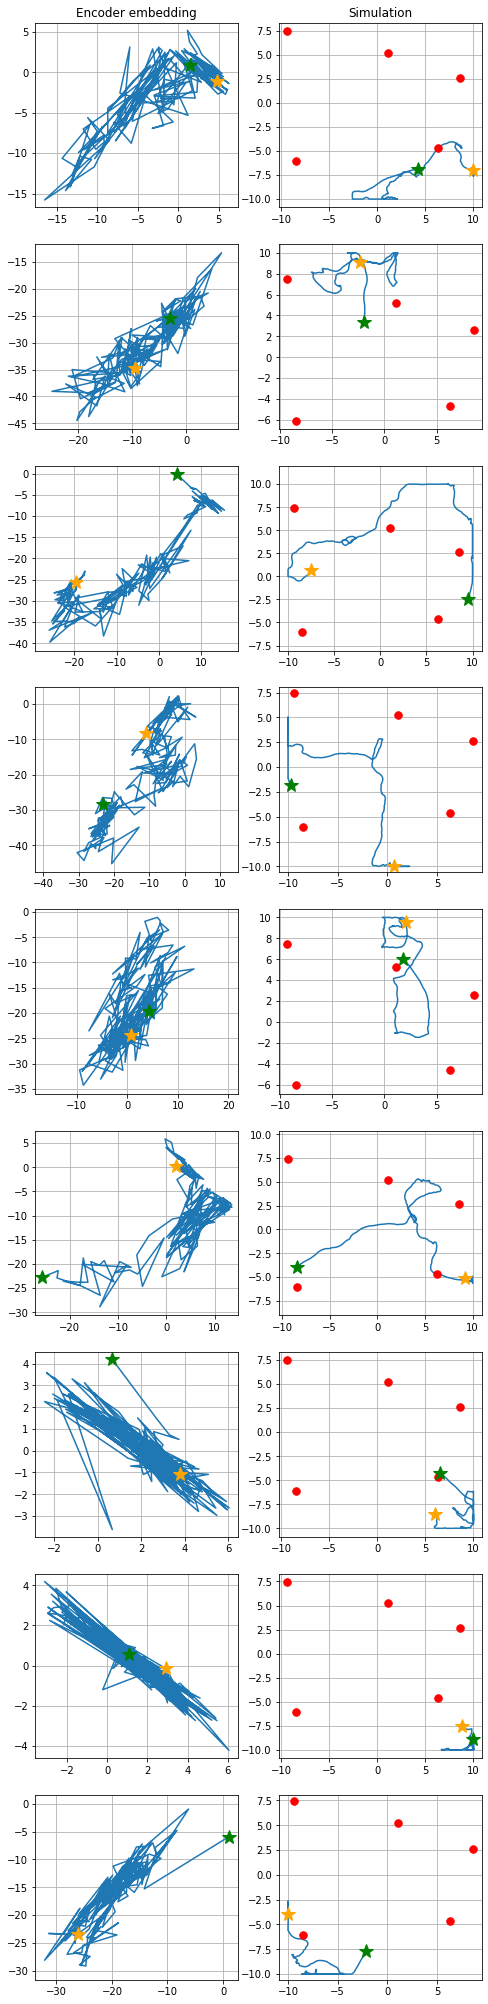

In [60]:
plot_embedding(result_with_rescaled_recovery_loss['model'][0] , data, range(9))

### Rescaled recovery loss with big weight on rtt

In [147]:
%%time

model_with_rescaled_and_reweighted_recovery_loss = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 10.0
    }
]

train_losses_with_rescaled_and_reweighted_recovery_loss, test_losses_with_rescaled_and_reweighted_recovery_loss = train_encoder_with_constraints(model_with_rescaled_and_reweighted_recovery_loss, train_loader, test_loader, 5 * N_EPOCHS, loss_functions)
result_with_rescaled_and_reweighted_recovery_loss = {
    'model': model_with_rescaled_and_reweighted_recovery_loss,
    'train_loss': train_losses_with_rescaled_and_reweighted_recovery_loss,
    'test_loss': test_losses_with_rescaled_and_reweighted_recovery_loss
}

CPU times: user 8min 12s, sys: 7.85 s, total: 8min 20s
Wall time: 8min 21s


In [148]:
# Save result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
save_result(result_with_rescaled_and_reweighted_recovery_loss, result_name)

In [61]:
# Load result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
result_with_rescaled_and_reweighted_recovery_loss = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

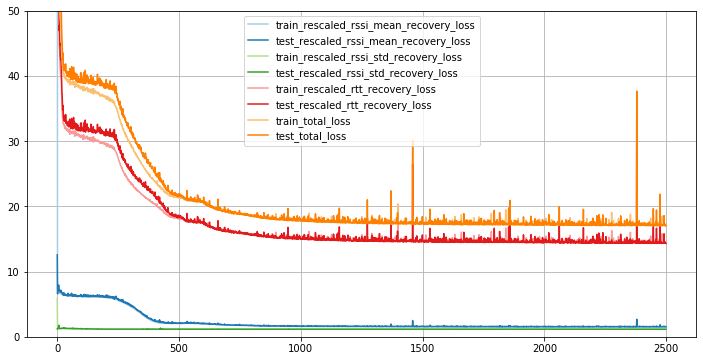

In [62]:
plot_multiloss_evolution(result_with_rescaled_and_reweighted_recovery_loss['train_loss'], result_with_rescaled_and_reweighted_recovery_loss['test_loss'], ylim=[0,50])

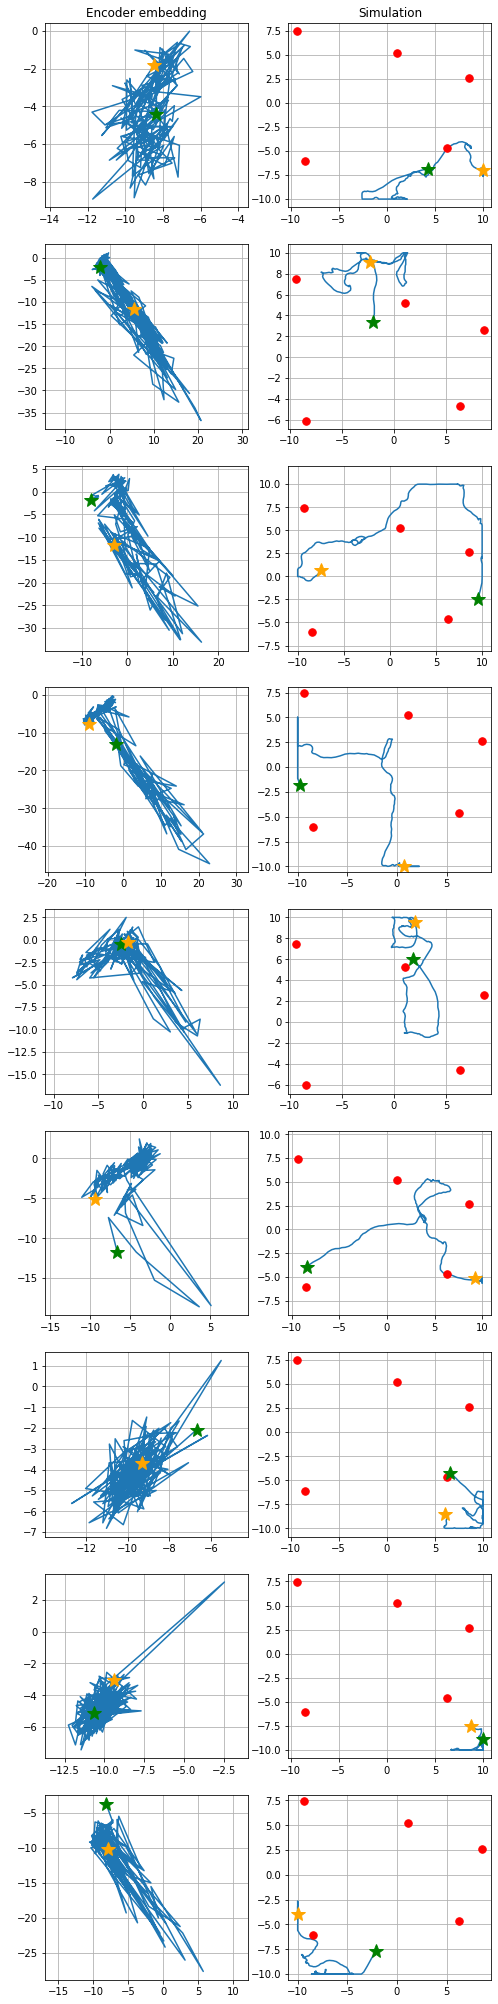

In [63]:
plot_embedding(result_with_rescaled_and_reweighted_recovery_loss['model'][0] , data, range(9))

### Rescaled recovery loss with big weight on rtt and subsequent distances loss

In [62]:
%%time

model_with_rescaled_and_reweighted_recovery_loss_and_dist = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 10.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 100.0
    }
]

train_losses_with_rescaled_and_reweighted_recovery_loss_and_dist, test_losses_with_rescaled_and_reweighted_recovery_loss_and_dist = train_encoder_with_constraints(model_with_rescaled_and_reweighted_recovery_loss_and_dist, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_rescaled_and_reweighted_recovery_loss_and_dist = {
    'model': model_with_rescaled_and_reweighted_recovery_loss_and_dist,
    'train_loss': train_losses_with_rescaled_and_reweighted_recovery_loss_and_dist,
    'test_loss': test_losses_with_rescaled_and_reweighted_recovery_loss_and_dist
}

CPU times: user 18min 39s, sys: 17.6 s, total: 18min 57s
Wall time: 18min 58s


In [63]:
# Save result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss_and_dist'
save_result(result_with_rescaled_and_reweighted_recovery_loss_and_dist, result_name)

In [64]:
# Load result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss_and_dist'
result_with_rescaled_and_reweighted_recovery_loss_and_dist = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

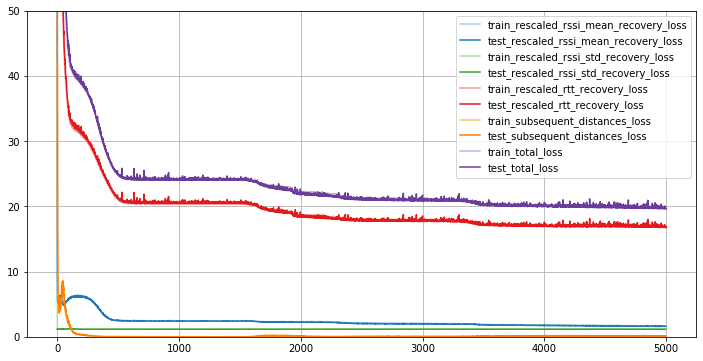

In [65]:
plot_multiloss_evolution(result_with_rescaled_and_reweighted_recovery_loss_and_dist['train_loss'], result_with_rescaled_and_reweighted_recovery_loss_and_dist['test_loss'], ylim=[0,50])

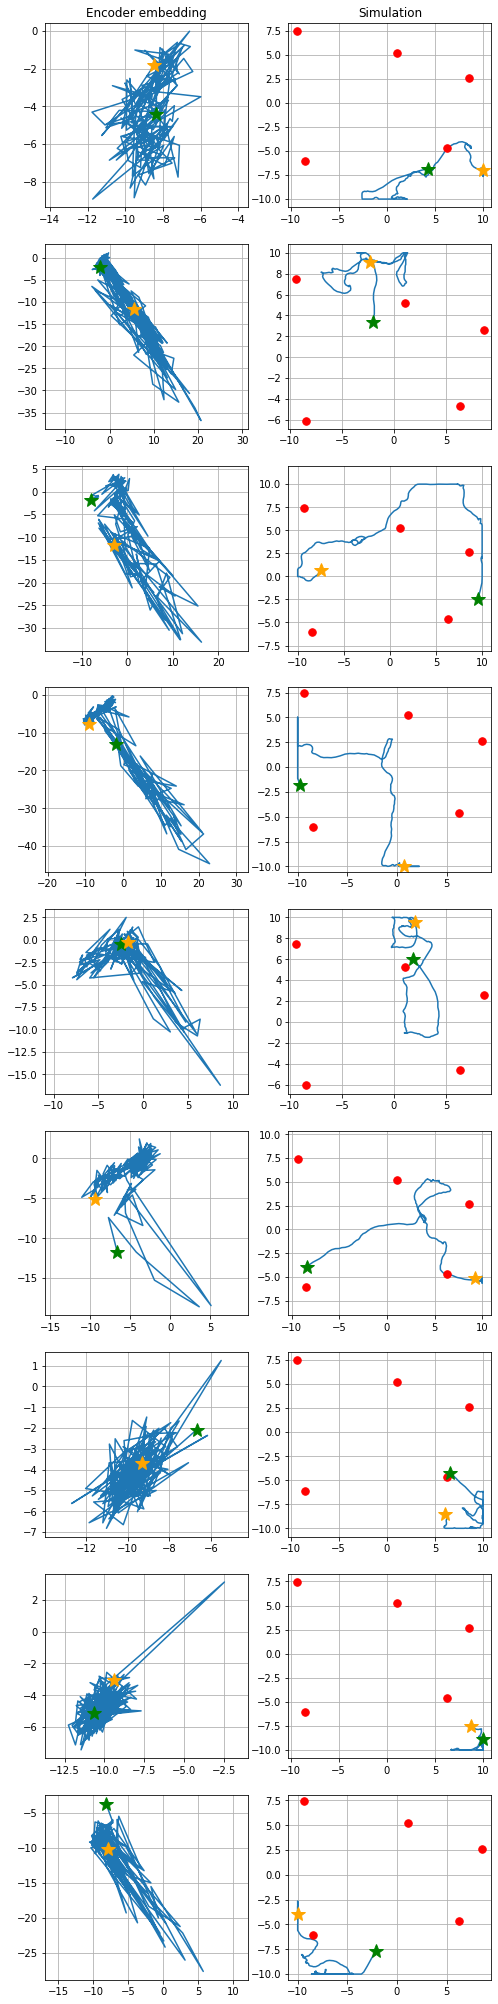

In [66]:
plot_embedding(result_with_rescaled_and_reweighted_recovery_loss['model'][0] , data, range(9))

## Different autoencoder architectures

### With tanh

In [84]:
%%time

model_2D_tanh = create_autoencoder_model(input_dim, hid_dim, bot_dim=2, activation=nn.Tanh())

train_losses_2D_tanh, test_losses_2D_tanh = train_encoder(model_2D_tanh, train_loader, test_loader, 20 * N_EPOCHS)
result_2D_tanh = {
    'model': model_2D_tanh,
    'train_loss': train_losses_2D_tanh,
    'test_loss': test_losses_2D_tanh
}

CPU times: user 1h 10min 55s, sys: 21 s, total: 1h 11min 16s
Wall time: 18min 36s


In [85]:
# Save result
result_name = 'autoencoder_2D_tanh'
save_result(result_2D_tanh, result_name)

In [67]:
# Load result
result_name = 'autoencoder_2D_tanh'
result_2D_tanh = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2, nn.Tanh()))

---

(0, 100)

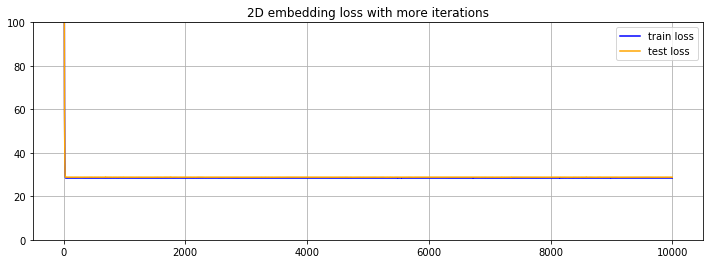

In [68]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D_tanh['train_loss'], result_2D_tanh['test_loss'])
plt.ylim([0,100])

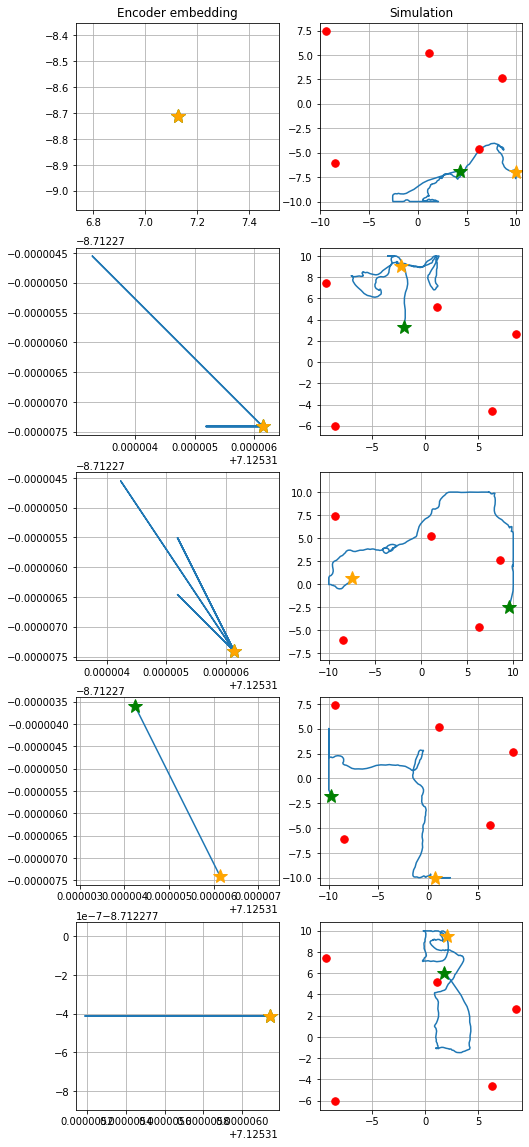

In [69]:
plot_embedding(result_2D_tanh['model'][0], data, range(5))

### With bigger hidden layer

In [71]:
big_hid_dim = 50

In [103]:
%%time

model_2D_big_hid = create_autoencoder_model(input_dim, big_hid_dim, bot_dim=2)

train_losses_2D_big_hid, test_losses_2D_big_hid = train_encoder(model_2D_big_hid, train_loader, test_loader, 10 * N_EPOCHS)
result_2D_big_hid = {
    'model': model_2D_big_hid,
    'train_loss': train_losses_2D_big_hid,
    'test_loss': test_losses_2D_big_hid
}

CPU times: user 1h 17min 58s, sys: 13.3 s, total: 1h 18min 12s
Wall time: 11min 41s


In [104]:
# Save result
result_name = 'autoencoder_2D_big_hid'
save_result(result_2D_big_hid, result_name)

In [72]:
# Load result
result_name = 'autoencoder_2D_big_hid'
result_2D_big_hid = load_result(result_name, create_autoencoder_model(input_dim, big_hid_dim, 2, nn.Tanh()))

---

(0, 25)

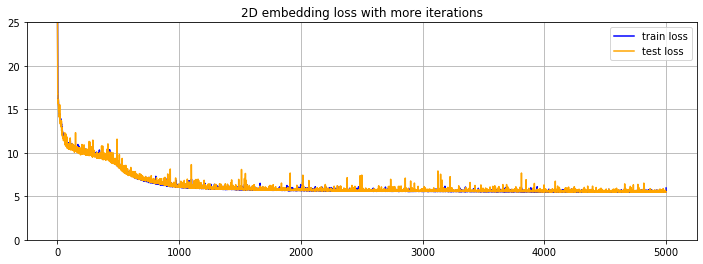

In [73]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D_big_hid['train_loss'], result_2D_big_hid['test_loss'])
plt.ylim([0,25])

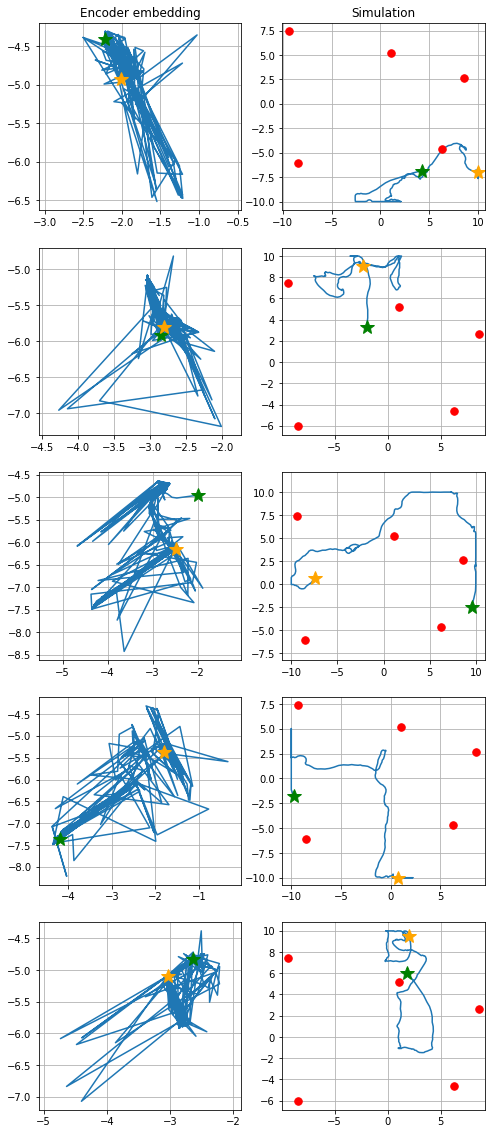

In [74]:
plot_embedding(result_2D_big_hid['model'][0], data, range(5))

### With small hidden layer

In [75]:
small_hid_dim = 6

In [113]:
%%time

model_2D_small_hid = create_autoencoder_model(input_dim, small_hid_dim, bot_dim=2)

train_losses_2D_small_hid, test_losses_2D_small_hid = train_encoder(model_2D_small_hid, train_loader, test_loader, 20 * N_EPOCHS)
result_2D_small_hid = {
    'model': model_2D_small_hid,
    'train_loss': train_losses_2D_small_hid,
    'test_loss': test_losses_2D_small_hid
}

CPU times: user 18min 23s, sys: 24.3 s, total: 18min 47s
Wall time: 18min 45s


In [114]:
# Save result
result_name = 'autoencoder_2D_small_hid'
save_result(result_2D_small_hid, result_name)

In [76]:
# Load result
result_name = 'autoencoder_2D_small_hid'
result_2D_small_hid = load_result(result_name, create_autoencoder_model(input_dim, small_hid_dim, 2, nn.Tanh()))

---

(0, 25)

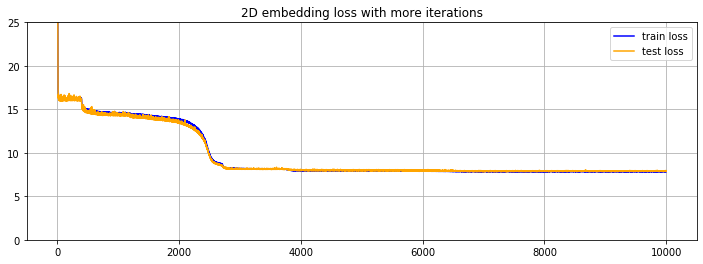

In [77]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D_small_hid['train_loss'], result_2D_small_hid['test_loss'])
plt.ylim([0,25])

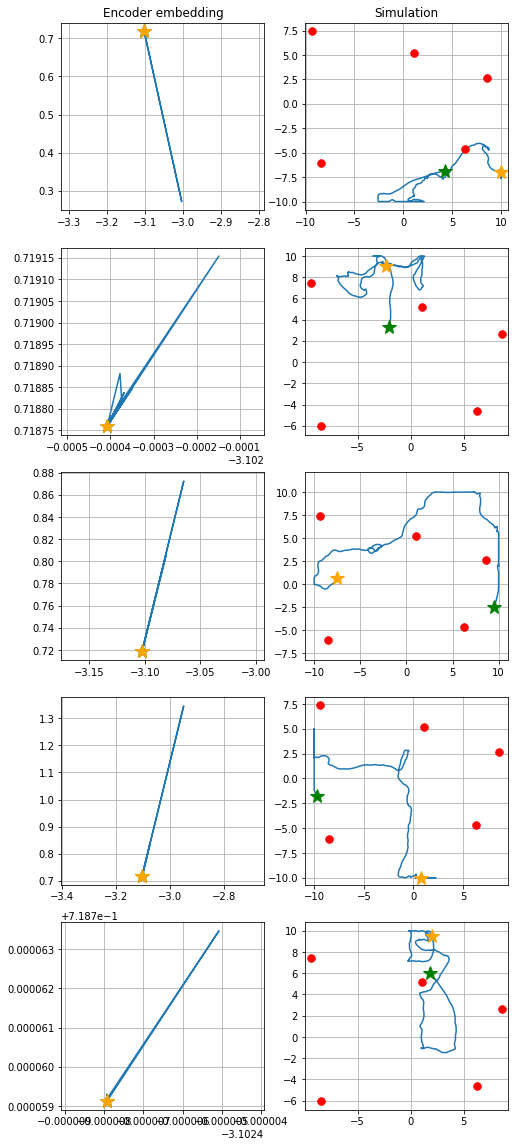

In [78]:
plot_embedding(result_2D_small_hid['model'][0], data, range(5))

### With more layers

In [79]:
def create_autoencoder_model_2hls(input_dim, hid_dim1, hid_dim2, bot_dim, activation=nn.ReLU()):
    encoder = nn.Sequential(
        nn.Linear(input_dim, hid_dim1), activation,
        nn.Linear(hid_dim1, hid_dim2), activation,
        nn.Linear(hid_dim2, bot_dim)
    )

    decoder = nn.Sequential(
        nn.Linear(bot_dim, hid_dim2), activation,
        nn.Linear(hid_dim2, hid_dim1), activation,
        nn.Linear(hid_dim1, input_dim)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    return model

In [80]:
hid_dim1 = 12
hid_dim2 = 6

In [124]:
%%time

model_2D_2hls = create_autoencoder_model_2hls(input_dim, hid_dim1, hid_dim2, bot_dim=2)

train_losses_2D_2hls, test_losses_2D_2hls = train_encoder(model_2D_2hls, train_loader, test_loader, 20 * N_EPOCHS)
result_2D_2hls = {
    'model': model_2D_2hls,
    'train_loss': train_losses_2D_2hls,
    'test_loss': test_losses_2D_2hls
}

CPU times: user 25min 40s, sys: 32.6 s, total: 26min 13s
Wall time: 26min 17s


In [126]:
# Save result
result_name = 'autoencoder_2D_2hls'
save_result(result_2D_2hls, result_name)

In [81]:
# Load result
result_name = 'autoencoder_2D_2hls'
result_2D_2hls = load_result(result_name, create_autoencoder_model_2hls(input_dim, hid_dim1, hid_dim2, bot_dim=2))

---

(0, 25)

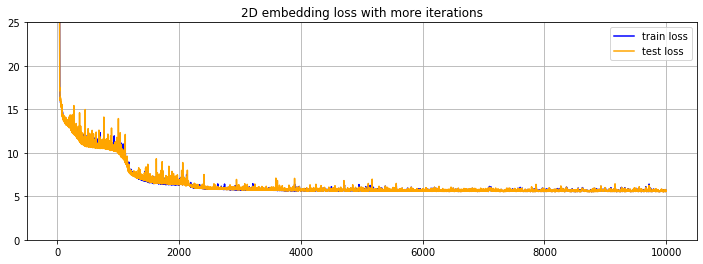

In [82]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D_2hls['train_loss'], result_2D_2hls['test_loss'])
plt.ylim([0,25])

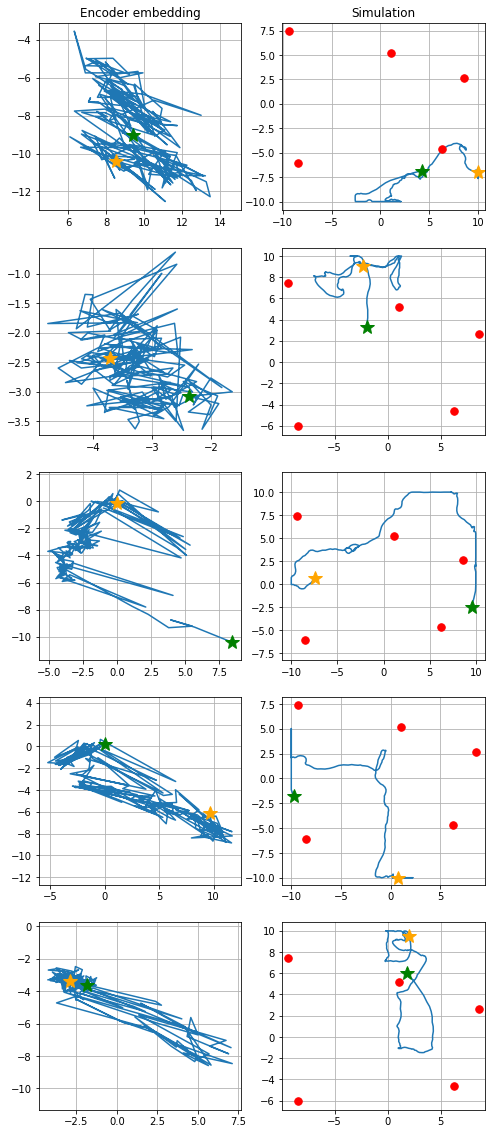

In [83]:
plot_embedding(result_2D_2hls['model'][0], data, range(5))

## RNN based autoencoder

In [71]:
input_dim = 3 * N_ANCHORS
hid_dim = 12
output_dim = 2

### RNN in first layer

In [72]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.nn_out = nn.Linear(input_dim + hidden_dim, hidden_dim)
        
    def forward(self, x, hidden):
        input_ = torch.cat((x, hidden), dim=-1)
        output = self.nn_out(input_)
            
        return output

In [73]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.rnn = RNN(input_dim, hid_dim)
        self.lin = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, hidden):
        new_hidden = self.rnn(x, hidden)
        output = self.lin(relu(new_hidden))
        return output, new_hidden

In [74]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.lin = nn.Linear(input_dim, hid_dim)
        self.rnn = RNN(hid_dim, output_dim)
        
    def forward(self, x, hidden):
        y = relu(self.lin(x))
        output = self.rnn(y, hidden)
        return output, output

In [75]:
BATCH_SIZE_RNN = 200
train_loader_rnn, test_loader_rnn = data.get_random_loaders(0.8, BATCH_SIZE_RNN)

In [76]:
def imu_loss_rnn(previous_encoded, new_encoded, previous_target, new_target):
    dirs_target = new_target.sub(previous_target)
    dirs_encoded = new_encoded.sub(previous_encoded)
    return mse_loss(dirs_target, dirs_encoded)

In [77]:
def train_encoder_rnn(encoder_rnn, decoder_rnn, train_loader, test_loader, nb_epochs, optimizer, loss_function=nn.MSELoss()):
    """Train a model"""
    
    train_losses = []
    test_losses = []

    for e in tqdm.tqdm(range(nb_epochs)):
        losses = []
        encoder_rnn.train()
        decoder_rnn.train()
        for batch_input, batch_target in train_loader:
            hidden_enc = torch.zeros(batch_input.size(0), encoder_rnn.hid_dim)
            hidden_dec = torch.zeros(batch_input.size(0), decoder_rnn.output_dim)
            input_ = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            for step_idx, (step_input, step_target) in enumerate(zip(input_, target)):
                if step_idx % 10 == 0:
                    # occasionnally break the graph
                    hidden_enc = hidden_enc.detach()
                    hidden_dec = hidden_dec.detach()
                
                encoded, hidden_enc = encoder_rnn(step_input, hidden_enc)
                decoded, hidden_dec = decoder_rnn(encoded, hidden_dec)
                
                loss = loss_function(decoded, step_input)
                
                if step_idx > 0:
                    loss = loss + 40 * imu_loss_rnn(prev_encoded, encoded, prev_target, step_target)
                    
                prev_encoded = encoded
                prev_target = step_target
            
                optimizer.zero_grad() # set gradients to zero
                loss.backward(retain_graph=True) # compute gradients
                optimizer.step() # update weights
                losses.append(loss.item())
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        encoder_rnn.eval()
        decoder_rnn.eval()
        for batch_input, batch_target in test_loader:
            hidden_enc = torch.zeros(batch_input.size(0), encoder_rnn.hid_dim)
            hidden_dec = torch.zeros(batch_input.size(0), decoder_rnn.output_dim)
            input_ = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            for step_idx, (step_input, step_target) in enumerate(zip(input_, target)):
                encoded, hidden_enc = encoder_rnn(step_input, hidden_enc)
                decoded, hidden_dec = decoder_rnn(encoded, hidden_dec)
            
                loss = loss_function(decoded, step_input)
                
                if step_idx > 0:
                    loss = loss + imu_loss_rnn(prev_encoded, encoded, prev_target, step_target)
                    
                prev_encoded = encoded
                prev_target = step_target
                
                losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [78]:
encoder_rnn = Encoder(input_dim, hid_dim, output_dim)
decoder_rnn = Decoder(output_dim, hid_dim, input_dim)

#### Train

In [79]:
optimizer = optim.Adam(chain(encoder_rnn.parameters(), decoder_rnn.parameters()))
train_losses_rnn, test_losses_rnn = train_encoder_rnn(encoder_rnn, decoder_rnn, train_loader_rnn, test_loader_rnn, 1500, optimizer)
result_rnn = {
    'model': [encoder_rnn, decoder_rnn],
    'train_loss': train_losses_rnn,
    'test_loss': test_losses_rnn
}

100%|██████████| 1500/1500 [16:17<00:00,  1.54it/s]


In [81]:
result_rnn = {
    'model': nn.Sequential(encoder_rnn, decoder_rnn),
    'train_loss': train_losses_rnn,
    'test_loss': test_losses_rnn
}

#### Save result

In [82]:
# Save result
result_name = 'autoencoder_rnn'
save_result(result_rnn, result_name)

#### Load result

In [ ]:
# Load result
result_name = 'autoencoder_rnn'
result_rnn = load_result(result_name, nn.Sequential(Encoder(input_dim, hid_dim, output_dim), Decoder(output_dim, hid_dim, input_dim)))
encoder_rnn, decoder_rnn = result_rnn['model']

#### Visualize result

(0, 50)

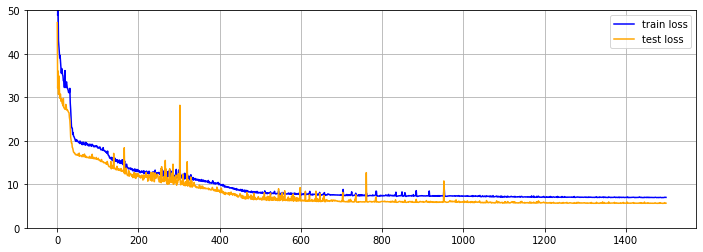

In [83]:
plt.figure(figsize=(12,4))
plot_loss_evolution(result_rnn['train_loss'], result_rnn['test_loss'])
plt.ylim([0,50])

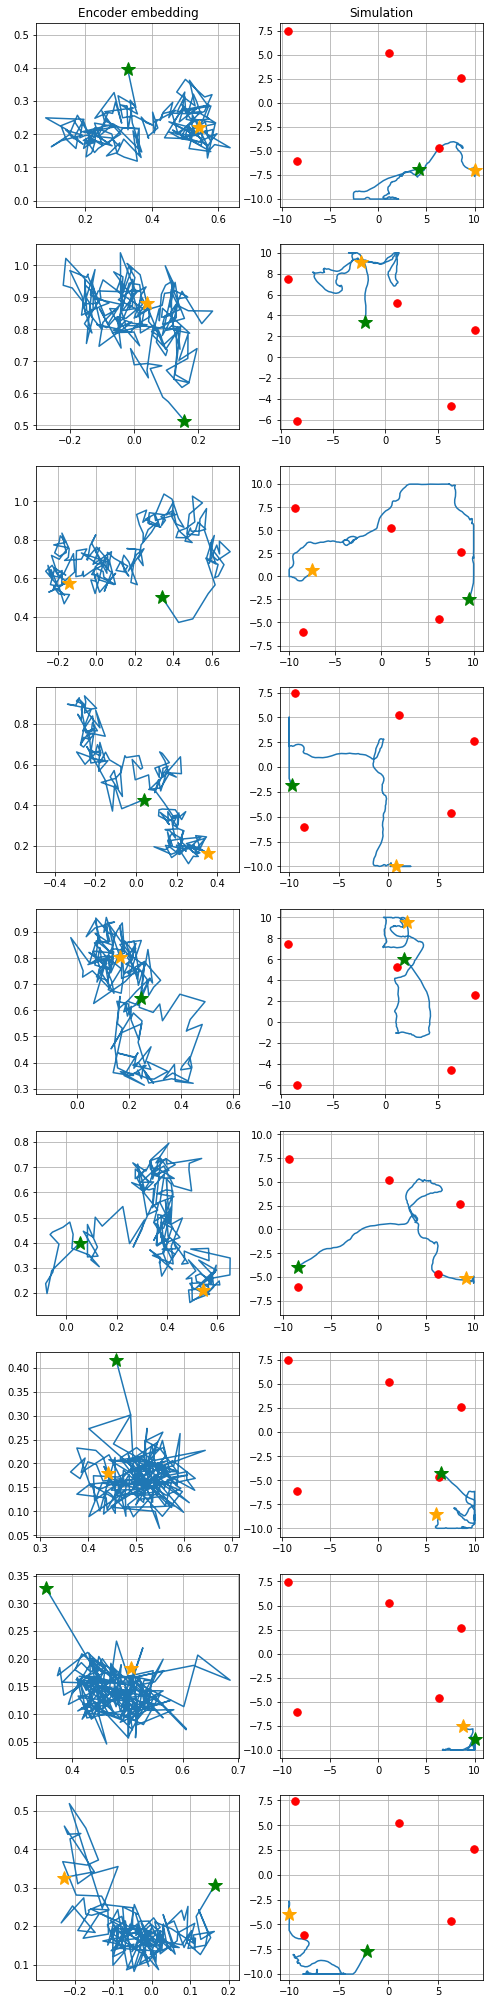

In [84]:
plot_embedding(encoder_rnn, data, range(9), hidden=torch.zeros(9, hid_dim))

---

### RNN in second layer

In [34]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.lin = nn.Linear(input_dim, hid_dim)
        self.rnn = RNN(hid_dim, output_dim)
        
    def forward(self, x, hidden):
        y = relu(self.lin(x))
        output = self.rnn(y, hidden)
        return output, output

In [35]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.rnn = RNN(input_dim, hid_dim)
        self.lin = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, hidden):
        y = self.rnn(x, hidden)
        output = self.lin(relu(y))
        return output, y

In [51]:
def train_encoder_rnn(encoder_rnn, decoder_rnn, train_loader, test_loader, nb_epochs, optimizer, loss_function=nn.MSELoss()):
    """Train a model"""
    
    train_losses = []
    test_losses = []

    for e in tqdm.tqdm(range(nb_epochs)):
        losses = []
        encoder_rnn.train()
        decoder_rnn.train()
        for batch_input, batch_target in train_loader:
            hidden_enc = torch.zeros(batch_input.size(0), encoder_rnn.output_dim)
            hidden_dec = torch.zeros(batch_input.size(0), decoder_rnn.hid_dim)
            input_ = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            for step_idx, (step_input, step_target) in enumerate(zip(input_, target)):
                if step_idx % 10 == 0:
                    # occasionnally break the graph
                    hidden_enc = hidden_enc.detach()
                    hidden_dec = hidden_dec.detach()
                
                encoded, hidden_enc = encoder_rnn(step_input, hidden_enc)
                decoded, hidden_dec = decoder_rnn(encoded, hidden_dec)
                
                loss = loss_function(decoded, step_input)
                
                if step_idx > 0:
                    loss = loss + 40 * imu_loss_rnn(prev_encoded, encoded, prev_target, step_target)
                    
                prev_encoded = encoded
                prev_target = step_target
            
                optimizer.zero_grad() # set gradients to zero
                loss.backward(retain_graph=True) # compute gradients
                optimizer.step() # update weights
                losses.append(loss.item())
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        encoder_rnn.eval()
        decoder_rnn.eval()
        for batch_input, batch_target in test_loader:
            hidden_enc = torch.zeros(batch_input.size(0), encoder_rnn.output_dim)
            hidden_dec = torch.zeros(batch_input.size(0), decoder_rnn.hid_dim)
            input_ = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            for step_idx, (step_input, step_target) in enumerate(zip(input_, target)):
                encoded, hidden_enc = encoder_rnn(step_input, hidden_enc)
                decoded, hidden_dec = decoder_rnn(encoded, hidden_dec)
            
                loss = loss_function(decoded, step_input)
                
                if step_idx > 0:
                    loss = loss + imu_loss_rnn(prev_encoded, encoded, prev_target, step_target)
                    
                prev_encoded = encoded
                prev_target = step_target
                
                losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [52]:
encoder_rnn = Encoder(input_dim, hid_dim, output_dim)
decoder_rnn = Decoder(output_dim, hid_dim, input_dim)

#### Train

In [54]:
optimizer = optim.Adam(chain(encoder_rnn.parameters(), decoder_rnn.parameters()))
train_losses_rnn, test_losses_rnn = train_encoder_rnn(encoder_rnn, decoder_rnn, train_loader_rnn, test_loader_rnn, 1500, optimizer)
result_rnn = {
    'model': [encoder_rnn, decoder_rnn],
    'train_loss': train_losses_rnn,
    'test_loss': test_losses_rnn
}

100%|██████████| 1500/1500 [14:34<00:00,  1.72it/s]


#### Save result

In [22]:
# Save result
result_name = 'autoencoder_rnn2'
save_result(result_2D, result_name)

#### Load result

In [16]:
# Load result
result_name = 'autoencoder_rnn2'
result_2D = load_result(result_name, create_autoencoder_model(2))

#### Visualize result

(0, 50)

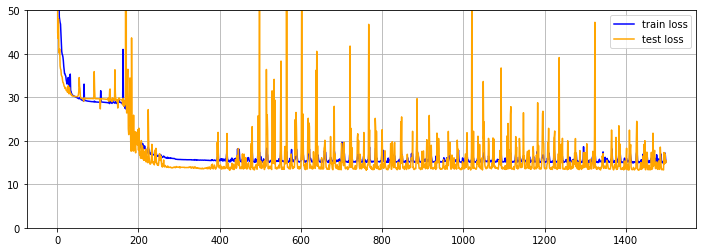

In [62]:
plt.figure(figsize=(12,4))
plot_loss_evolution(result_rnn['train_loss'], result_rnn['test_loss'])
plt.ylim([0,50])

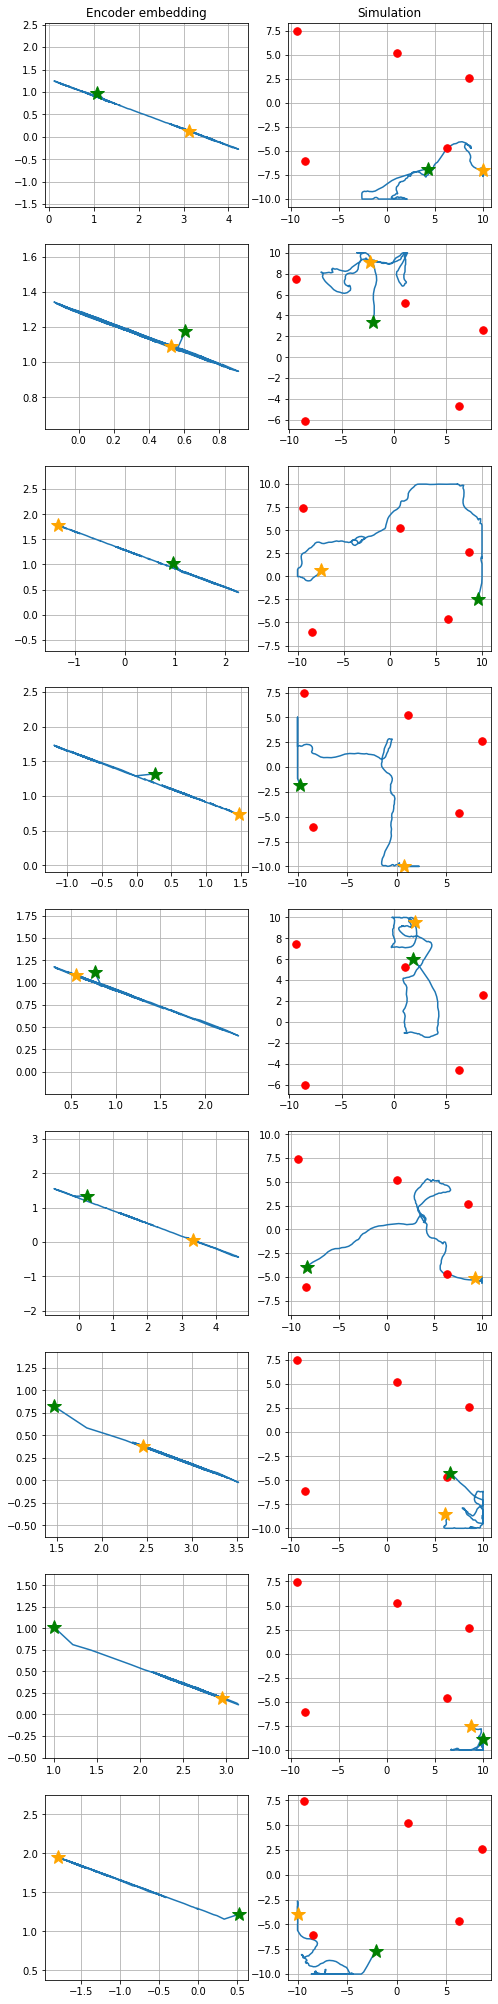

In [58]:
plot_embedding(encoder_rnn, data, range(9), hidden=torch.zeros(9, output_dim))